<a href="https://colab.research.google.com/github/OWNA/Liberal/blob/Code/Liberal2_CollabReady.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Setup Environment

This cell installs the required Python libraries and mounts Google Drive to persist data, models, and logs across sessions.

In [ ]:
import os # Import os here for makedirs

# Install necessary libraries
# Using -q for quieter installation, remove it for verbose output
print("Installing required libraries...")
# Main Bot Libraries
!pip install ccxt lightgbm scikit-learn pandas matplotlib scipy numpy -q
!pip install optuna shap EMD-signal PyYAML -q
# L2 Collector Library
!pip install websocket-client -q
print("Libraries installation attempt finished.")

# Mount Google Drive
print("\nMounting Google Drive...")
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True) # force_remount can be useful
    print("Google Drive mounted successfully.")
    # Define a base directory on Google Drive (adjust as needed)
    # NOTE: This path is also set in the config file below. Ensure they match or load from config.
    DRIVE_BASE_DIR = '/content/drive/MyDrive/trading_bot_project_v2'
    os.makedirs(DRIVE_BASE_DIR, exist_ok=True)
    print(f"Using Google Drive base directory: {DRIVE_BASE_DIR}")
except ImportError:
    print("Google Drive mounting failed (not in Colab environment?). Using local directory.")
    DRIVE_BASE_DIR = "./trading_bot_project_v2_local" # Fallback local directory
    os.makedirs(DRIVE_BASE_DIR, exist_ok=True)
    print(f"Using local base directory: {DRIVE_BASE_DIR}")
except Exception as e:
    print(f"An error occurred during Google Drive mounting: {e}")
    DRIVE_BASE_DIR = "./trading_bot_project_v2_local" # Fallback local directory
    os.makedirs(DRIVE_BASE_DIR, exist_ok=True)
    print(f"Using local base directory due to error: {DRIVE_BASE_DIR}")

# Store the determined base directory as an environment variable for easy access
%env BOT_BASE_DIR={DRIVE_BASE_DIR}

Installing required libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 135.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that 

## 2. Configuration Settings

Define all hyperparameters, paths, and settings for the trading bot run in a YAML configuration block. This makes it easy to manage experiments. The configuration is saved to `config.yaml`.

In [ ]:
import yaml
import os

# Get the base directory determined in the previous cell
# If the environment variable wasn't set, default to a local path
bot_base_dir = os.environ.get('BOT_BASE_DIR', './trading_bot_project_v2_local')
config_path = os.path.join(bot_base_dir, 'config.yaml')

# Define configuration as a Python dictionary
config = {
    # --- General Settings ---
    "base_dir": bot_base_dir, # Use the path determined during Drive mount
    "symbol": "BTC/USDT",
    "timeframe": "1m", # Changed back to 5m as 1m caused issues

    # --- Feature Engineering ---
    "feature_window": 24,
    "use_l2_features": True, # *** Enable L2 features (primarily for simulation loop) ***
    "l2_depth_levels": 25, # Number of levels to use for L2 calculations (e.g., OBI, depth ratio)

    # --- Data Fetching ---
    "fetch_ohlcv_limit": 2500, # Initial historical data fetch
    "l2_depth": 25, # Depth for fetching L2 order book (used in simulation)

    # --- Model Training ---
    "optuna_trials": 100,
    "test_size": 0.2, # Train/validation split for Optuna

    # --- Backtesting ---
    "backtest_threshold": 0.2, # Signal threshold (adjust based on results)
    "initial_balance": 10000,
    "commission_pct": 0.0006,
    "leverage": 3,
    "stop_loss_pct": None, # Optional: e.g., 0.02 for 2%
    "take_profit_pct": None, # Optional: e.g., 0.04 for 4%

    # --- Live Simulation ---
    "run_simulation_flag": True, # Set to True to run simulation
    "simulation_threshold": 0.2, # Signal threshold for simulation
    "fetch_live_limit": 300, # Candles to fetch in sim loop
    "simulation_duration_seconds": 300, # How long to run sim in example

    # --- Analysis ---
    "use_shap_override": True, # Attempt to use SHAP if available

    # --- L2 Collector Specific Settings (Can be overridden in Collector Cell) ---
    "collector_symbol": "BTCUSDT", # Note: CCXT uses '/', Bybit WS uses ''
    "collector_duration": 5,
    "collector_unit": "minutes",
    "collector_depth": 50,
    "collector_category": "linear"
}

# Save the configuration to a YAML file
print(f"Saving configuration to: {config_path}")
try:
    with open(config_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False, sort_keys=False)
    print("Configuration saved successfully.")
except Exception as e:
    print(f"Error saving configuration file: {e}")

# Optional: Print the configuration to verify
# print("\n--- Configuration ---")
# print(yaml.dump(config, default_flow_style=False))
# print("---------------------\n")

Saving configuration to: /content/drive/MyDrive/trading_bot_project_v2/config.yaml
Configuration saved successfully.


## 3. L2 Data Collector

This cell runs the Bybit Level 2 order book data collector using WebSockets. It saves the data snapshots to a `.jsonl` file. You can run this cell independently to collect data for a specified duration.

**Note:** The main trading bot (`CombinedTradingBot`) in this notebook primarily uses L2 features fetched via REST API during the *live simulation*. It does **not** automatically load or use the historical L2 data collected by this cell for backtesting or training unless you manually implement the logic to read the `.jsonl` file and merge it with OHLCV data *before* the `prepare_features` step.

In [ ]:
# === Requirements ===
# Make sure websocket-client is installed in your Colab environment (should be done in Cell 1)
# !pip install websocket-client -q

import websocket # Requires: pip install websocket-client
import json
import time
import threading
import traceback # Added for better error detail
from datetime import datetime, timezone, timedelta
# import signal # Signal handling might be less reliable in Colab, rely on KeyboardInterrupt
import sys
import os
import yaml # To load base dir from config if needed

# ==============================================================================
#                           CONFIGURATION (Collector)
# ==============================================================================
# --- Set your desired parameters here before running the cell ---
# --- These override the defaults set in the main config.yaml if needed ---

# Load base directory from environment variable set in Cell 1
COLLECTOR_BASE_DIR = os.environ.get('BOT_BASE_DIR', './trading_bot_project_v2_local')

# Try loading collector settings from config.yaml, use defaults if not found
config_file_path_collector = os.path.join(COLLECTOR_BASE_DIR, 'config.yaml')
try:
    with open(config_file_path_collector, 'r') as f:
        main_config = yaml.safe_load(f)
    COLLECTOR_SYMBOL = main_config.get('collector_symbol', "BTCUSDT")
    COLLECTOR_DURATION = main_config.get('collector_duration', 5)
    COLLECTOR_UNIT = main_config.get('collector_unit', "minutes")
    COLLECTOR_DEPTH = main_config.get('collector_depth', 50)
    COLLECTOR_CATEGORY = main_config.get('collector_category', "linear")
    print("Loaded collector settings from config.yaml")
except Exception as e:
    print(f"Warning: Could not load collector settings from config.yaml ({e}). Using defaults.")
    COLLECTOR_SYMBOL = "BTCUSDT"
    COLLECTOR_DURATION = 5
    COLLECTOR_UNIT = "minutes"
    COLLECTOR_DEPTH = 50
    COLLECTOR_CATEGORY = "linear"

# Construct the output file path within a 'l2_data' subdirectory
L2_DATA_SUBDIR = os.path.join(COLLECTOR_BASE_DIR, 'l2_data')
FILENAME = f"{COLLECTOR_SYMBOL.lower()}_l2_data_{COLLECTOR_DURATION}{COLLECTOR_UNIT[0]}.jsonl" # e.g., btcusdt_l2_data_5m.jsonl
COLLECTOR_OUTPUT_FILE = os.path.join(L2_DATA_SUBDIR, FILENAME)

# ==============================================================================
print(f"--- Collector Configuration ---")
print(f"Symbol:   {COLLECTOR_SYMBOL}")
print(f"Duration: {COLLECTOR_DURATION} {COLLECTOR_UNIT}")
print(f"Depth:    {COLLECTOR_DEPTH}")
print(f"Category: {COLLECTOR_CATEGORY}")
print(f"Output File: {COLLECTOR_OUTPUT_FILE}")
print(f"-----------------------------")
# ==============================================================================


# --- Global Variables (Collector Specific) ---
collector_ws_connection = None
collector_output_file_handle = None
collector_snapshot_data = {"bids": {}, "asks": {}}
collector_last_update_id = 0
collector_ws_thread_object = None
collector_lock = threading.Lock()
collector_write_counter = 0
collector_main_loop_running = True # Flag for main loop control

# --- WebSocket Event Handlers (Collector Specific) ---

def collector_on_message(ws, message):
    """Handles incoming WebSocket messages for the collector."""
    global collector_snapshot_data, collector_last_update_id, collector_output_file_handle, collector_lock, collector_write_counter
    # No need to check main_loop_running here, rely on WS closure and thread join

    try:
        data = json.loads(message)
        # Handle ping/pong
        if "op" in data and data.get("op") == "ping":
            ws.send(json.dumps({"op": "pong", "req_id": data.get("req_id")}))
            return
        # Handle subscription confirmation
        if "op" in data and data.get("op") == "subscribe":
            if data.get("success"):
                print(f"Successfully subscribed to: {data.get('ret_msg')}")
            else:
                print(f"Subscription failed: {data.get('ret_msg')}")
            return

        # Process order book data
        if "topic" in data and "orderbook" in data["topic"]:
            data_content = data.get("data", {})
            update_id = data_content.get("u")
            timestamp_ms = data.get("ts") # Timestamp from Bybit message
            if not update_id or not timestamp_ms:
                # print(f"Skipping message, missing update_id or timestamp_ms: {data}") # Optional debug
                return # Skip if essential data missing

            with collector_lock: # Lock before accessing/modifying shared snapshot_data
                if data.get("type") == "snapshot":
                    print(f"[{datetime.now(timezone.utc).isoformat(timespec='seconds')}] Received initial snapshot (Update ID: {update_id})")
                    collector_snapshot_data["bids"] = {price: vol for price, vol in data_content.get("b", [])}
                    collector_snapshot_data["asks"] = {price: vol for price, vol in data_content.get("a", [])}
                    collector_last_update_id = update_id
                    collector_save_snapshot_locked(timestamp_ms) # Call locked version

                elif data.get("type") == "delta":
                    # Apply updates only if the update ID is newer than the last processed one
                    if update_id > collector_last_update_id:
                        # Apply bid updates
                        for price, vol in data_content.get("b", []):
                            if float(vol) == 0: # Remove level
                                collector_snapshot_data["bids"].pop(price, None)
                            else: # Add/Update level
                                collector_snapshot_data["bids"][price] = vol
                        # Apply ask updates
                        for price, vol in data_content.get("a", []):
                            if float(vol) == 0: # Remove level
                                collector_snapshot_data["asks"].pop(price, None)
                            else: # Add/Update level
                                collector_snapshot_data["asks"][price] = vol
                        collector_last_update_id = update_id
                        collector_save_snapshot_locked(timestamp_ms) # Call locked version
                    # else:
                        # print(f"Ignoring stale update (Last: {collector_last_update_id}, Current: {update_id})") # Optional debug

    except json.JSONDecodeError:
        print(f"Error decoding JSON: {message}")
    except Exception as e:
        print(f"Error processing message: {e}\n{message}")
        traceback.print_exc()

def collector_save_snapshot_locked(bybit_timestamp_ms):
    """Saves snapshot. Assumes collector_lock is already held."""
    global collector_snapshot_data, collector_output_file_handle, collector_write_counter, collector_last_update_id
    if collector_output_file_handle and not collector_output_file_handle.closed:
        try:
            # Convert dicts back to sorted lists [price, volume] for saving
            # Sort bids descending, asks ascending by price (numeric conversion needed)
            bids_list = sorted([[p, v] for p, v in collector_snapshot_data["bids"].items()], key=lambda x: float(x[0]), reverse=True)
            asks_list = sorted([[p, v] for p, v in collector_snapshot_data["asks"].items()], key=lambda x: float(x[0]))

            snapshot_to_save = {
                "timestamp_ms": bybit_timestamp_ms, # Use Bybit's timestamp
                "local_timestamp_iso": datetime.now(timezone.utc).isoformat(), # Add local timestamp for reference
                "b": bids_list,
                "a": asks_list,
                "last_update_id": collector_last_update_id
            }

            collector_output_file_handle.write(json.dumps(snapshot_to_save) + '\n')
            collector_output_file_handle.flush() # Ensure data is written promptly
            collector_write_counter += 1
        except Exception as e:
            print(f"\nError writing to file: {e}")
            traceback.print_exc()

def collector_on_error(ws, error):
    """Handles WebSocket errors for the collector."""
    print(f"\nWebSocket Error: {error}")
    global collector_main_loop_running
    collector_main_loop_running = False # Signal main loop to stop

def collector_on_close(ws, close_status_code, close_msg):
    """Handles WebSocket connection close for the collector."""
    print(f"\nWebSocket Closed: Code={close_status_code}, Msg={close_msg}")
    global collector_main_loop_running
    collector_main_loop_running = False # Ensure main loop stops

def collector_on_open(ws, symbol, depth):
    """Sends subscription message when connection opens for the collector."""
    print("WebSocket Connection Opened")
    # Construct the subscription topic string (remove slashes for WebSocket topic)
    clean_symbol = symbol.replace("/", "")
    topic = f"orderbook.{depth}.{clean_symbol}"
    subscribe_message = {"op": "subscribe", "args": [topic]}
    try:
        ws.send(json.dumps(subscribe_message))
        print(f"Sent subscription request for: {topic}")
    except Exception as e:
        print(f"Error sending subscribe message: {e}")
        ws.close() # Close WS if subscribe fails

# --- Main Execution Logic (Collector) ---
def run_websocket_collector(symbol, depth, category):
    """Starts the WebSocket connection for the collector."""
    global collector_ws_connection, collector_ws_thread_object
    # Determine endpoint based on category
    if category == 'spot':
        ws_url = "wss://stream.bybit.com/v5/public/spot"
    elif category == 'inverse':
         ws_url = "wss://stream.bybit.com/v5/public/inverse"
    else: # Default to linear
        ws_url = "wss://stream.bybit.com/v5/public/linear"

    print(f"Connecting to WebSocket: {ws_url}")
    # Note: Pass symbol and depth to on_open using lambda
    collector_ws_connection = websocket.WebSocketApp(ws_url,
                                  on_open=lambda ws: collector_on_open(ws, symbol, depth),
                                  on_message=collector_on_message,
                                  on_error=collector_on_error,
                                  on_close=collector_on_close)

    # Run in a separate thread to allow main thread to handle timing/shutdown
    # Use ping_interval and ping_timeout for keepalive
    collector_ws_thread_object = threading.Thread(target=lambda: collector_ws_connection.run_forever(ping_interval=20, ping_timeout=10))
    collector_ws_thread_object.daemon = True # Allow main thread to exit even if this thread is running
    collector_ws_thread_object.start()
    print("WebSocket thread started.")

# --- Colab Execution Block (Collector) ---
duration_seconds = COLLECTOR_DURATION * 60 if COLLECTOR_UNIT == 'minutes' else COLLECTOR_DURATION * 3600
start_time = time.time()
end_time = start_time + duration_seconds

# Reset global state variables for the collector before each run
collector_ws_connection = None
collector_output_file_handle = None
collector_snapshot_data = {"bids": {}, "asks": {}}
collector_last_update_id = 0
collector_ws_thread_object = None
collector_write_counter = 0
collector_main_loop_running = True # Reset flag

try:
    # Ensure output directory exists
    output_dir = os.path.dirname(COLLECTOR_OUTPUT_FILE)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")

    # Open output file
    collector_output_file_handle = open(COLLECTOR_OUTPUT_FILE, 'w')
    print(f"Opened output file for writing: {COLLECTOR_OUTPUT_FILE}")

    # Start WebSocket
    run_websocket_collector(COLLECTOR_SYMBOL, COLLECTOR_DEPTH, COLLECTOR_CATEGORY)

    # Main loop to check duration
    print(f"Collecting data for {COLLECTOR_DURATION} {COLLECTOR_UNIT}...")
    print(f"Target end time: {datetime.fromtimestamp(end_time, timezone.utc).isoformat()}")

    while collector_main_loop_running and time.time() < end_time:
        # Check if WebSocket thread is still alive
        if collector_ws_thread_object and not collector_ws_thread_object.is_alive():
            print("\nWebSocket thread stopped unexpectedly.")
            collector_main_loop_running = False # Stop main loop
            break

        # Keep the main thread alive, WebSocket runs in background
        time.sleep(1.0) # Check every second

        # Optional: Print progress (only if loop is still supposed to be running)
        if collector_main_loop_running:
            remaining_time = max(0, int(end_time - time.time()))
            print(f"Time remaining: {timedelta(seconds=remaining_time)} | Snapshots saved: {collector_write_counter}   ", end='\r')

except KeyboardInterrupt:
    print("\nKeyboard interrupt detected.")
    collector_main_loop_running = False # Signal shutdown

finally:
    print("\nInitiating shutdown...")

    # 1. Signal WebSocket to close
    if collector_ws_connection:
        print("Signalling WebSocket connection to close...")
        try:
            collector_ws_connection.close()
        except Exception as e:
            print(f"Error signalling WebSocket close: {e}")

    # 2. Wait for WebSocket thread to finish
    if collector_ws_thread_object and collector_ws_thread_object.is_alive():
        print("Waiting for WebSocket thread to join...")
        collector_ws_thread_object.join(timeout=10.0) # Wait up to 10 seconds
        if collector_ws_thread_object.is_alive():
            print("Warning: WebSocket thread did not join within timeout.")
        else:
            print("WebSocket thread joined.")

    # 3. Close the file handle (now that WS thread should be stopped)
    # Use lock just in case, though WS thread should be dead
    with collector_lock:
        if collector_output_file_handle and not collector_output_file_handle.closed:
            print(f"Closing output file: {collector_output_file_handle.name} (Snapshots saved: {collector_write_counter})")
            try:
                collector_output_file_handle.close()
            except Exception as e:
                print(f"Error closing file handle: {e}")
        collector_output_file_handle = None # Ensure handle is cleared

    print(f"Data collection script finished. Total snapshots saved: {collector_write_counter}")
    # Final check for resource cleanup
    if collector_output_file_handle:
        print("Warning: Output file handle may not be None after shutdown.")
    if collector_ws_thread_object and collector_ws_thread_object.is_alive():
        print("Warning: WebSocket thread may still be alive after shutdown.")

# --- End of Collector Execution Block ---

Loaded collector settings from config.yaml
--- Collector Configuration ---
Symbol:   BTCUSDT
Duration: 5 minutes
Depth:    50
Category: linear
Output File: /content/drive/MyDrive/trading_bot_project_v2/l2_data/btcusdt_l2_data_5m.jsonl
-----------------------------
Opened output file for writing: /content/drive/MyDrive/trading_bot_project_v2/l2_data/btcusdt_l2_data_5m.jsonl
Connecting to WebSocket: wss://stream.bybit.com/v5/public/linear
WebSocket thread started.
Target end time: 2025-05-14T23:27:47.196276+00:00
WebSocket Connection Opened
Sent subscription request for: orderbook.50.BTCUSDT
[2025-05-14T23:22:48+00:00] Received initial snapshot (Update ID: 108042550)
Successfully subscribed to: 
Time remaining: 0:00:00 | Snapshots saved: 7291   
Initiating shutdown...
Signalling WebSocket connection to close...

WebSocket Closed: Code=None, Msg=None
Closing output file: /content/drive/MyDrive/trading_bot_project_v2/l2_data/btcusdt_l2_data_5m.jsonl (Snapshots saved: 7291)
Data collection 

## 4. Imports & Global Setup (Main Bot)

Import libraries, load the configuration from `config.yaml`, set up API keys from Colab Secrets, and handle optional dependencies for the main trading bot.

In [ ]:
# --- Core Libraries ---
import os
import threading
import time
import json
import traceback
import warnings
from datetime import datetime, timezone, timedelta
import sys
import yaml # For loading config

# --- Data Handling & Numerics ---
import pandas as pd
import numpy as np

# --- Machine Learning ---
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# --- Load Configuration ---
print("Loading configuration...")
config_file_path = os.path.join(os.environ.get('BOT_BASE_DIR', './trading_bot_project_v2_local'), 'config.yaml')
try:
    with open(config_file_path, 'r') as f:
        config = yaml.safe_load(f)
    print("Configuration loaded successfully.")
    # You can access config values like config['symbol'], config['timeframe'] etc.
except FileNotFoundError:
    print(f"ERROR: Configuration file not found at {config_file_path}. Please run the config cell (Cell 2).")
    config = {} # Provide empty dict to avoid downstream errors
except Exception as e:
    print(f"Error loading configuration: {e}")
    config = {}

# --- Optional Libraries Setup ---

# Optuna
try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    print("Optuna loaded.")
except ImportError:
    print("WARNING: Optuna not found. Model training will fail.")

# PyEMD (EMD-signal)
try:
    from PyEMD import EMD
    HAS_PYEMD = True
    print("PyEMD (EMD-signal) library loaded successfully.")
except ImportError:
    print("Warning: PyEMD (EMD-signal) not found. HHT features disabled.")
    HAS_PYEMD = False
    class EMD: # Dummy class
        def __init__(self, *args, **kwargs): pass
        def __call__(self, signal, *args, **kwargs): return np.empty((0, len(signal))) if isinstance(signal, np.ndarray) else None
        def get_imfs_and_residue(self): return np.empty((0,0)), np.empty((0))

# SHAP
try:
    import shap
    HAS_SHAP = True
    print("SHAP library loaded successfully.")
except ImportError:
    print("Warning: SHAP library not found. SHAP plots disabled.")
    HAS_SHAP = False

# Matplotlib
try:
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-v0_8-darkgrid')
    print("Matplotlib loaded.")
except ImportError:
    print("Warning: Matplotlib not found. Plotting disabled.")
    plt = None

# Scipy (for Hilbert)
try:
    from scipy.signal import hilbert
    print("Scipy (signal.hilbert) loaded.")
except ImportError:
    print("ERROR: Scipy not found. Hilbert transform (needed for HHT) will fail.")
    # If HHT is critical, raise error. Otherwise, HAS_PYEMD check handles it.
    # raise ImportError("Scipy is required but not installed.")


# --- Exchange Interaction ---
try:
    import ccxt
    print("CCXT loaded.")
except ImportError:
    print("ERROR: CCXT not found. Exchange interaction will fail.")
    raise ImportError("CCXT is required but not installed.")


# --- API Key Loading (Using Colab Secrets) ---
print("\nLoading API Keys from Colab Secrets...")
BYBIT_API_KEY = None
BYBIT_API_SECRET = None
try:
    # Try importing the specific Colab module
    from google.colab import userdata
    # Fetch secrets using the correct names
    BYBIT_API_KEY = userdata.get("BYBIT_API_KEY_MAIN")
    BYBIT_API_SECRET = userdata.get("BYBIT_API_SECRET_MAIN")
    if BYBIT_API_KEY and BYBIT_API_SECRET:
        print("API Keys loaded successfully from Colab secrets.")
    else:
        print("*** WARNING: API Keys not found in Colab secrets (or value is empty). ***")
        print("*** Check secret names ('BYBIT_API_KEY_MAIN', 'BYBIT_API_SECRET_MAIN') and values in Colab UI. ***")
        print("*** Proceeding with public access (may fail due to geo-blocking). ***")
        BYBIT_API_KEY = None # Ensure they are None if fetch failed
        BYBIT_API_SECRET = None
except ImportError:
    # Fallback for non-Colab environments (won't load secrets)
    print("*** WARNING: Not running in Colab environment. Cannot load Colab secrets. ***")
    print("*** Proceeding with public access (may fail due to geo-blocking). ***")
    BYBIT_API_KEY = None
    BYBIT_API_SECRET = None
except Exception as e:
    print(f"An unexpected error occurred loading secrets: {e}")
    BYBIT_API_KEY = None
    BYBIT_API_SECRET = None

# --- Warnings Configuration ---
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

print("\nImports and global setup complete.")

Loading configuration...
Configuration loaded successfully.
Optuna loaded.
PyEMD (EMD-signal) library loaded successfully.
SHAP library loaded successfully.
Matplotlib loaded.
Scipy (signal.hilbert) loaded.
CCXT loaded.

Loading API Keys from Colab Secrets...
API Keys loaded successfully from Colab secrets.

Imports and global setup complete.


In [ ]:
# Essential Imports
import os
import threading
import time
import json
import traceback
import warnings
from datetime import datetime, timezone, timedelta
import sys
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import ccxt
import pickle # For saving/loading ensemble models

# Optional Imports (check for availability)
try:
    import pandas_ta as ta
    HAS_PANDAS_TA = True
    # print("Pandas TA library loaded successfully.")
except ImportError:
    print("Warning: pandas_ta library not found. Advanced TA features will be disabled.")
    HAS_PANDAS_TA = False

try:
    from PyEMD import EMD
    HAS_PYEMD = True
    # print("PyEMD library loaded successfully.")
except ImportError:
    print("Warning: PyEMD library not found. HHT features will be disabled.")
    HAS_PYEMD = False
    class EMD: # Dummy class if PyEMD is not available
        def __init__(self, *args, **kwargs): pass
        def __call__(self, signal, *args, **kwargs): return np.empty((0, len(signal))) if isinstance(signal, np.ndarray) else None

try:
    from scipy.signal import hilbert
    HAS_SCIPY_HILBERT = True
    # print("Scipy.signal.hilbert loaded successfully.")
except ImportError:
    print("Warning: Scipy.signal.hilbert not found. HHT features requiring it will fail.")
    HAS_SCIPY_HILBERT = False
    def hilbert(signal): # Dummy function
        print("Error: hilbert function called but scipy.signal.hilbert not available.")
        return np.zeros_like(signal)

try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Reduce Optuna's verbosity
    HAS_OPTUNA = True
    # print("Optuna loaded.")
except ImportError:
    print("Warning: Optuna not found. Model training requiring it will fail.")
    HAS_OPTUNA = False

try:
    import shap
    HAS_SHAP = True
    # print("SHAP loaded.")
except ImportError:
    print("Warning: SHAP library not found. SHAP plots will be disabled.")
    HAS_SHAP = False

try:
    import matplotlib.pyplot as plt
    # plt.style.use('seaborn-v0_8-darkgrid') # Optional: set a style
    HAS_MATPLOTLIB = True
    # print("Matplotlib loaded.")
except ImportError:
    print("Warning: Matplotlib not found. Plotting will be disabled.")
    HAS_MATPLOTLIB = False
    plt = None # Dummy plt object

# ==========================================================================
# MODULE 6: ADVANCED RISK MANAGER CLASS
# ==========================================================================
class AdvancedRiskManager:
    """
    Manages risk through dynamic position sizing, volatility-adjusted stops,
    and take profit levels.
    """
    def __init__(self, risk_config):
        self.max_drawdown = risk_config.get('max_drawdown', 0.20)
        self.volatility_lookback = risk_config.get('volatility_lookback', 14)
        self.position_sizing_mode = risk_config.get('position_sizing_mode', 'volatility_target')
        self.volatility_target_pct = risk_config.get('volatility_target_pct', 0.02)
        self.max_equity_risk_pct = risk_config.get('max_equity_risk_pct', 0.10)
        self.fixed_fraction_pct = risk_config.get('fixed_fraction_pct', 0.05)
        self.sl_atr_multiplier = risk_config.get('sl_atr_multiplier', 1.5)
        self.tp_atr_multiplier = risk_config.get('tp_atr_multiplier', 2.0)

    def calculate_position_size(self, account_equity, current_volatility_pct):
        if self.position_sizing_mode == 'volatility_target':
            if current_volatility_pct <= 1e-5:
                return account_equity * self.max_equity_risk_pct * 0.1
            size_usd = (account_equity * self.volatility_target_pct) / current_volatility_pct
            max_size_usd = account_equity * self.max_equity_risk_pct
            return min(size_usd, max_size_usd)
        elif self.position_sizing_mode == 'fixed_fraction':
            return account_equity * self.fixed_fraction_pct
        else:
            return account_equity * self.fixed_fraction_pct

    def calculate_stop_loss(self, entry_price, atr_value, side='long'):
        if not pd.notna(atr_value) or atr_value <= 0: return None
        if side == 'long': return entry_price - (atr_value * self.sl_atr_multiplier)
        elif side == 'short': return entry_price + (atr_value * self.sl_atr_multiplier)
        return None

    def calculate_take_profit(self, entry_price, atr_value, side='long'):
        if not pd.notna(atr_value) or atr_value <= 0: return None
        if side == 'long': return entry_price + (atr_value * self.tp_atr_multiplier)
        elif side == 'short': return entry_price - (atr_value * self.tp_atr_multiplier)
        return None

# ==========================================================================
# MODULE 7: SMART ORDER EXECUTOR CLASS
# ==========================================================================
class SmartOrderExecutor:
    """
    Handles order execution with considerations for slippage and order book dynamics.
    """
    def __init__(self, exchange_api, exec_config):
        self.exchange = exchange_api
        self.slippage_model_pct = exec_config.get('slippage_model_pct', 0.0005)
        self.max_levels = exec_config.get('max_order_book_levels', 20)

    def _walk_book(self, order_book_side_snapshot, amount_to_trade):
        filled_amount = 0
        total_cost_or_revenue = 0
        if not order_book_side_snapshot: return None, 0
        for price_level, volume_at_level in order_book_side_snapshot:
            if filled_amount >= amount_to_trade: break
            try:
                price = float(price_level); volume = float(volume_at_level)
                if price <=0 or volume <=0: continue
            except (ValueError, TypeError): continue
            can_fill_this_level = min(volume, amount_to_trade - filled_amount)
            total_cost_or_revenue += can_fill_this_level * price
            filled_amount += can_fill_this_level
        if filled_amount == 0: return None, 0
        return total_cost_or_revenue / filled_amount, filled_amount

    def execute_order(self, symbol, side, amount, desired_price, order_type='limit'):
        if not self.exchange: print("Error (SmartExec): Exchange API not available."); return None
        if amount <= 1e-8: return None
        estimated_fill_price = desired_price; final_limit_price = desired_price
        try:
            if order_type == 'limit':
                current_book = self.exchange.fetch_l2_order_book(symbol, limit=self.max_levels)
                if current_book:
                    if side == 'buy' and current_book.get('asks'):
                        avg_price, _ = self._walk_book(current_book['asks'], amount)
                        if avg_price is not None: estimated_fill_price = avg_price
                    elif side == 'sell' and current_book.get('bids'):
                        avg_price, _ = self._walk_book(current_book['bids'], amount)
                        if avg_price is not None: estimated_fill_price = avg_price
            if order_type == 'limit':
                if side == 'buy': final_limit_price = estimated_fill_price * (1 + self.slippage_model_pct)
                elif side == 'sell': final_limit_price = estimated_fill_price * (1 - self.slippage_model_pct)
        except Exception as e: final_limit_price = desired_price
        try:
            params = {}
            if order_type == 'limit':
                return self.exchange.create_order(symbol=symbol, type='limit', side=side, amount=amount, price=final_limit_price, params=params)
            elif order_type == 'market':
                 return self.exchange.create_order(symbol=symbol, type='market', side=side, amount=amount, params=params)
            else: return None
        except Exception as e: print(f"Error (SmartExec) placing order for {symbol}: {e}"); return None

class CombinedTradingBot:
    def __init__(self, config, api_key=None, api_secret=None):
        self.config = config
        self.symbol = config['symbol']
        self.timeframe = config['timeframe']
        self.base_dir = config['base_dir']
        self.feature_window = config['feature_window']
        self.l2_depth = config.get('l2_depth', 25)
        self.l2_depth_levels = config.get('l2_depth_levels', 20)
        self.api_key = api_key
        self.api_secret = api_secret

        self.ohlcv_base_features = ["z_close", "z_volume", "z_spread"]
        self.ta_features = []
        if HAS_PANDAS_TA: self.ta_features = ['kama', 'supertrend', 'vwap', 'atr', 'rsi']

        self.hht_features = []
        if HAS_PYEMD:
            for i in range(3): # Max 3 IMFs for features
                self.hht_features.extend([f'hht_freq_imf{i}', f'hht_amp_imf{i}'])

        self.l2_features = ['depth_imb_5', 'depth_imb_10', 'depth_imb_20', 'price_impact_10', 'bid_curve', 'ask_curve']

        self.feature_list = list(self.ohlcv_base_features)
        if self.ta_features: self.feature_list.extend(self.ta_features)
        if self.hht_features: self.feature_list.extend(self.hht_features)
        if self.config.get('use_l2_features', False) and self.l2_features: self.feature_list.extend(self.l2_features)

        os.makedirs(self.base_dir, exist_ok=True)
        safe_symbol = self.symbol.replace('/', '_').replace(':', '')
        self.model_path = os.path.join(self.base_dir, f"lgbm_model_{safe_symbol}_{self.timeframe}.txt")
        self.ensemble_model_path = os.path.join(self.base_dir, f"ensemble_models_{safe_symbol}_{self.timeframe}.pkl")
        self.features_json_path = os.path.join(self.base_dir, f"model_features_{safe_symbol}_{self.timeframe}.json")
        self.prepared_data_path = os.path.join(self.base_dir, f"prepared_data_{safe_symbol}_{self.timeframe}.csv")
        self.ohlcv_data_path = os.path.join(self.base_dir, f"ohlcv_data_{safe_symbol}_{self.timeframe}.csv")
        collector_symbol_safe = config.get('collector_symbol', 'BTCUSDT').lower()
        collector_duration = config.get('collector_duration', 5)
        collector_unit_char = config.get('collector_unit', 'minutes')[0]
        l2_collector_filename = f"{collector_symbol_safe}_l2_data_{collector_duration}{collector_unit_char}.jsonl"
        self.l2_raw_data_path = os.path.join(self.base_dir, 'l2_data', l2_collector_filename)
        self.backtest_log_path = os.path.join(self.base_dir, f"backtest_log_{safe_symbol}_{self.timeframe}.csv")
        self.simulation_log_path = os.path.join(self.base_dir, f"simulation_log_{safe_symbol}_{self.timeframe}.csv")
        self.imf_plot_path = os.path.join(self.base_dir, f"emd_imf_plot_{safe_symbol}_{self.timeframe}.png")
        self.feature_plot_path = os.path.join(self.base_dir, f"feature_vs_price_plot_{safe_symbol}_{self.timeframe}.png")
        self.shap_bar_plot_path = os.path.join(self.base_dir, f"shap_bar_plot_{safe_symbol}_{self.timeframe}.png")
        self.shap_dot_plot_path = os.path.join(self.base_dir, f"shap_dot_plot_{safe_symbol}_{self.timeframe}.png")
        self.lgbm_importance_plot_path = os.path.join(self.base_dir, f"lgbm_importance_plot_{safe_symbol}_{self.timeframe}.png")
        self.backtest_equity_plot_path = os.path.join(self.base_dir, f"backtest_equity_curve_{safe_symbol}_{self.timeframe}.png")
        self.simulation_equity_plot_path = os.path.join(self.base_dir, f"simulation_equity_curve_{safe_symbol}_{self.timeframe}.png")

        self.exchange = None
        try:
            exchange_config = {'enableRateLimit': True, 'options': {'adjustForTimeDifference': True}}
            if self.api_key and self.api_secret: exchange_config.update({'apiKey': self.api_key, 'secret': self.api_secret})
            self.exchange = ccxt.bybit(exchange_config)
            self.exchange.load_markets()
        except Exception as e: print(f"FATAL: CCXT Exchange Error: {e}"); self.exchange = None

        self.target_mean = None; self.target_std = None
        self.model = None; self.trained_features = []
        self.ensemble_models = None

        self.live_equity_history = []; self.live_position_history = []
        self.live_timestamp_history = []; self.simulation_running = False
        self.simulation_stop_event = threading.Event(); self.simulation_thread = None
        self.current_live_position = {"side": None, "entry_price": 0, "size": 0, "timestamp": None, "sl_price": None, "tp_price": None, "entry_commission": 0.0}

        self.risk_manager = AdvancedRiskManager(self.config.get('risk_management', {}))
        if self.exchange: self.order_executor = SmartOrderExecutor(self.exchange, self.config.get('execution', {}))
        else: self.order_executor = None
        # print("Bot Initialized.") # Reduced verbosity

    def fetch_ohlcv(self, limit=None, since=None, max_retries=3, delay_seconds=5):
        if not self.exchange: return pd.DataFrame()
        limit = limit or self.config.get('fetch_ohlcv_limit', 1000)
        for attempt in range(max_retries):
            try:
                if since is None:
                    timeframe_duration_in_ms = self.exchange.parse_timeframe(self.timeframe) * 1000
                    # Ensure enough history for all rolling features (feature_window + EMD buffer + TA buffer)
                    buffer_candles = self.feature_window + 50 # General buffer
                    since = self.exchange.milliseconds() - (limit + buffer_candles) * timeframe_duration_in_ms
                ohlcv = self.exchange.fetch_ohlcv(self.symbol, timeframe=self.timeframe, since=since, limit=limit)
                if not ohlcv:
                    if attempt < max_retries - 1: time.sleep(delay_seconds * (2**attempt)); continue
                    return pd.DataFrame()
                df = pd.DataFrame(ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])
                df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True)
                return df.dropna() # Drop rows with any NaNs from fetch
            except Exception as e:
                if attempt < max_retries - 1: time.sleep(delay_seconds * (2**attempt)); continue
                print(f"Error fetching OHLCV: {e}"); return pd.DataFrame()
        return pd.DataFrame()

    def fetch_l2_order_book(self, limit=None, max_retries=3, delay_seconds=2):
        if not self.exchange or not self.exchange.has.get('fetchL2OrderBook'): return None
        fetch_limit = limit if limit is not None else self.l2_depth
        for _ in range(max_retries):
            try:
                order_book = self.exchange.fetch_l2_order_book(self.symbol, limit=fetch_limit)
                if (order_book and isinstance(order_book, dict) and
                    'bids' in order_book and isinstance(order_book['bids'], list) and
                    'asks' in order_book and isinstance(order_book['asks'], list)):
                    # Basic validation of price/volume pairs if lists are not empty
                    if order_book['bids'] and (not isinstance(order_book['bids'][0], list) or len(order_book['bids'][0]) != 2): return None
                    if order_book['asks'] and (not isinstance(order_book['asks'][0], list) or len(order_book['asks'][0]) != 2): return None
                    order_book['fetch_timestamp_ms'] = self.exchange.milliseconds()
                    return order_book
                time.sleep(delay_seconds); continue
            except Exception: time.sleep(delay_seconds); continue
        return None

    def clean_ohlcv_data(self, df):
        if df is None or df.empty: return pd.DataFrame()
        df = df.copy()
        if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True, errors='coerce')
        elif df['timestamp'].dt.tz is None: df['timestamp'] = df['timestamp'].dt.tz_localize('utc')
        else: df['timestamp'] = df['timestamp'].dt.tz_convert('utc')
        df.dropna(subset=['timestamp'], inplace=True)
        df.drop_duplicates(subset=['timestamp'], keep='last', inplace=True)
        df.sort_values('timestamp', inplace=True); df.reset_index(drop=True, inplace=True)
        ohlcv_cols = ["open", "high", "low", "close", "volume"]
        for col in ohlcv_cols: df[col] = pd.to_numeric(df[col], errors='coerce')
        df.dropna(subset=ohlcv_cols, inplace=True)
        df = df[(df['volume'] >= 0) & (df['open'] > 0) & (df['high'] > 0) & (df['low'] > 0) & (df['close'] > 0)]
        df = df[(df['high'] >= df['low']) & (df['high'] >= df['open']) & (df['high'] >= df['close']) &
                (df['low'] <= df['open']) & (df['low'] <= df['close'])]
        return df

    def _calculate_zscore_features(self, df):
        df = df.copy(); window = self.feature_window; min_periods = max(1, window // 2)
        for col in ["close", "volume"]:
            mean = df[col].rolling(window=window, min_periods=min_periods).mean()
            std = df[col].rolling(window=window, min_periods=min_periods).std().replace(0, np.nan)
            df[f'z_{col}'] = (df[col] - mean) / std
        return df

    def _calculate_spread_features(self, df):
        df = df.copy(); window = self.feature_window; min_periods = max(1, window // 2)
        df['spread'] = df['high'] - df['low']
        mean = df['spread'].rolling(window=window, min_periods=min_periods).mean()
        std = df['spread'].rolling(window=window, min_periods=min_periods).std().replace(0, np.nan)
        df['z_spread'] = (df['spread'] - mean) / std
        return df

    def _calculate_advanced_ta_features(self, df):
        if not HAS_PANDAS_TA: return df
        df = df.copy()
        for col in ['open', 'high', 'low', 'close', 'volume']: df[col] = pd.to_numeric(df[col], errors='coerce')
        try: df['kama'] = ta.kama(df['close'], length=20)
        except Exception: df['kama'] = np.nan
        try:
            st = ta.supertrend(df['high'], df['low'], df['close'], length=10, multiplier=3)
            if st is not None and not st.empty:
                 st_col = next((c for c in st.columns if 'SUPERT_' in c and not any(x in c for x in ['d','l','s'])), None)
                 df['supertrend'] = st[st_col] if st_col else np.nan
            else: df['supertrend'] = np.nan
        except Exception: df['supertrend'] = np.nan
        try: df['vwap'] = ta.vwap(df['high'], df['low'], df['close'], df['volume'])
        except Exception: df['vwap'] = np.nan
        try: df['atr'] = ta.atr(df['high'], df['low'], df['close'], length=self.config.get('risk_management',{}).get('volatility_lookback', 14))
        except Exception: df['atr'] = np.nan
        try: df['rsi'] = ta.rsi(df['close'], length=14)
        except Exception: df['rsi'] = np.nan
        return df

    def _calculate_hht_features(self, df):
        if not (HAS_PYEMD and HAS_SCIPY_HILBERT):
            for col in self.hht_features: df[col] = np.nan
            return df
        df = df.copy(); signal = df["close"].values.astype(float)
        for col in self.hht_features: df[col] = np.nan
        if len(signal) < self.feature_window + 20 : return df
        try:
            emd_instance = EMD(noise_width=0.05, DTYPE=np.float64)
            imfs = emd_instance(signal)
            if imfs is None or imfs.shape[0] == 0: return df
            for i in range(min(3, imfs.shape[0])):
                analytic_signal = hilbert(imfs[i])
                instantaneous_phase = np.unwrap(np.angle(analytic_signal))
                instantaneous_frequency = np.gradient(instantaneous_phase) / (2.0 * np.pi)
                instantaneous_amplitude = np.abs(analytic_signal)
                if len(instantaneous_frequency) == len(df): df[f'hht_freq_imf{i}'] = instantaneous_frequency
                if len(instantaneous_amplitude) == len(df): df[f'hht_amp_imf{i}'] = instantaneous_amplitude
        except Exception as e: print(f"Warning HHT: {e}")
        return df

    def _calculate_l2_features_from_snapshot(self, bids_snapshot, asks_snapshot):
        features = {col: np.nan for col in self.l2_features}
        try:
            if not bids_snapshot or not asks_snapshot: return features
            bids_np = np.array([[float(p), float(v)] for p,v in bids_snapshot if p is not None and v is not None and float(v)>0])
            asks_np = np.array([[float(p), float(v)] for p,v in asks_snapshot if p is not None and v is not None and float(v)>0])
            if bids_np.ndim != 2 or bids_np.shape[1] != 2 or bids_np.shape[0] == 0: return features
            if asks_np.ndim != 2 or asks_np.shape[1] != 2 or asks_np.shape[0] == 0: return features
            for depth in [5, 10, 20]:
                cb = bids_np[:min(depth, len(bids_np))]; ca = asks_np[:min(depth, len(asks_np))]
                bid_vol = np.sum(cb[:, 1]) if len(cb) > 0 else 0
                ask_vol = np.sum(ca[:, 1]) if len(ca) > 0 else 0
                total_vol = bid_vol + ask_vol
                features[f'depth_imb_{depth}'] = (bid_vol - ask_vol) / total_vol if total_vol > 0 else 0.0
            if len(bids_np) >= 5 and len(asks_np) >= 5:
                mid_price = (bids_np[0, 0] + asks_np[0, 0]) / 2.0
                if mid_price > 0: features['price_impact_10'] = (asks_np[4, 0] - bids_np[4, 0]) / mid_price
            num_curve = 20
            bp_c = bids_np[:min(num_curve, len(bids_np)), 0]; bv_c = bids_np[:min(num_curve, len(bids_np)), 1]
            ap_c = asks_np[:min(num_curve, len(asks_np)), 0]; av_c = asks_np[:min(num_curve, len(asks_np)), 1]
            if len(bp_c) > 1: features['bid_curve'], _ = np.polyfit(bp_c, bv_c, 1)
            if len(ap_c) > 1: features['ask_curve'], _ = np.polyfit(ap_c, av_c, 1)
        except Exception: pass # Silence L2 calc errors for now
        return features

    def _calculate_l2_features(self, df):
        df = df.copy()
        for col in self.l2_features: df[col] = np.nan
        return df

    def prepare_features(self, df_ohlcv, save=True):
        if df_ohlcv is None or df_ohlcv.empty: return pd.DataFrame()
        df = self.clean_ohlcv_data(df_ohlcv);
        if df.empty: return df
        df = self._calculate_zscore_features(df)
        df = self._calculate_spread_features(df)
        df = self._calculate_advanced_ta_features(df)
        df = self._calculate_hht_features(df)
        if self.config.get('use_l2_features', False): df = self._calculate_l2_features(df)

        required_non_nan = list(self.ohlcv_base_features)
        if HAS_PANDAS_TA: required_non_nan.extend(self.ta_features)
        if HAS_PYEMD and HAS_SCIPY_HILBERT: required_non_nan.extend(self.hht_features)
        required_non_nan = [f for f in required_non_nan if f in df.columns and f != 'atr'] # ATR can be NaN initially
        df.dropna(subset=required_non_nan, inplace=True)
        if df.empty: return df
        if save:
            try: df.to_csv(self.prepared_data_path, index=False)
            except Exception as e: print(f"Warning saving prepared data: {e}")
        return df

    def generate_enhanced_labels(self, df):
        if df is None or df.empty or 'close' not in df.columns: return pd.DataFrame()
        df = df.copy(); returns = df['close'].pct_change()
        vol_window = min(20, len(returns) -1) if len(returns) > 1 else 1
        volatility = returns.rolling(window=vol_window, min_periods=max(1, vol_window //2 )).std()
        df['target'] = returns.shift(-1) / (volatility + 1e-9)
        if df['target'].notna().sum() > 20:
            upper = df['target'].quantile(0.99); lower = df['target'].quantile(0.01)
            if pd.notna(lower) and pd.notna(upper) and lower < upper: df['target'] = df['target'].clip(lower, upper)
        df.dropna(subset=['target'], inplace=True)
        if not df.empty and df['target'].notna().any():
            self.target_mean = df['target'].mean()
            self.target_std = df['target'].std()
            if self.target_std == 0 or not pd.notna(self.target_std): self.target_std = 1e-9
        else: self.target_mean = 0; self.target_std = 1
        return df

    def train_model(self, df=None, save=True):
        if not HAS_OPTUNA: print("Optuna not available, cannot train standard model."); return None
        train_df = df.copy() if df is not None else pd.read_csv(self.prepared_data_path, parse_dates=['timestamp'])
        if train_df.empty: return None
        if "target" not in train_df.columns: train_df = self.generate_enhanced_labels(train_df)
        if train_df.empty or "target" not in train_df.columns: return None

        potential_features = list(self.feature_list)
        self.trained_features = []
        l2_cols_in_train = [f for f in self.l2_features if f in train_df.columns]
        l2_all_nan = train_df[l2_cols_in_train].isnull().all().all() if self.config.get('use_l2_features', False) and l2_cols_in_train else False
        for f in potential_features:
             if f in train_df.columns and not train_df[f].isnull().all():
                 if not (f in self.l2_features and l2_all_nan): self.trained_features.append(f)
        train_df.dropna(subset=self.trained_features + ['target'], inplace=True)
        if not self.trained_features or train_df.empty: return None
        X = train_df[self.trained_features]; y = train_df["target"]
        if len(X) < 50: return None
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.config.get('test_size', 0.2), shuffle=False)

        def objective(trial):
            params = {'objective': 'regression_l1', 'metric': 'mae', 'verbosity': -1, 'random_state': 42,
                      'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
                      'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
                      'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                      'max_depth': trial.suggest_int('max_depth', 3, 10),
                      'lambda_l1': trial.suggest_float('lambda_l1', 1e-7, 5.0, log=True),
                      'lambda_l2': trial.suggest_float('lambda_l2', 1e-7, 5.0, log=True),
                      'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
                      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
                      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                      'min_child_samples': trial.suggest_int('min_child_samples', 10, 60)}
            model = lgb.LGBMRegressor(**params)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mae', callbacks=[lgb.early_stopping(20, verbose=False)])
            return mean_absolute_error(y_val, model.predict(X_val))
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=self.config.get('optuna_trials', 30))
        final_params = study.best_params; final_params.update({'objective':'regression_l1','metric':'mae','verbosity':-1,'random_state':42})
        final_model = lgb.LGBMRegressor(**final_params); final_model.fit(X, y)
        self.model = final_model.booster_
        if save:
            try:
                self.model.save_model(self.model_path)
                with open(self.features_json_path, 'w') as f: json.dump(self.trained_features, f, indent=4)
            except Exception as e: print(f"Warning saving standard model: {e}")
        return self.model

    def train_ensemble_model(self, df=None, save=True):
        if not HAS_OPTUNA: print("Optuna not available, cannot train ensemble model effectively."); return None
        train_df = df.copy() if df is not None else pd.read_csv(self.prepared_data_path, parse_dates=['timestamp'])
        if train_df.empty: return None
        if "target" not in train_df.columns: train_df = self.generate_enhanced_labels(train_df)
        if train_df.empty or "target" not in train_df.columns: return None

        long_thresh = self.config.get('ensemble_long_thresh', 0.5); short_thresh = self.config.get('ensemble_short_thresh', -0.5)
        train_df['clf_target'] = 0
        train_df.loc[train_df['target'] > long_thresh, 'clf_target'] = 1
        train_df.loc[train_df['target'] < short_thresh, 'clf_target'] = -1
        train_df['clf_target'] = train_df['clf_target'].astype(int)

        potential_features = list(self.feature_list); current_trained_features = []
        l2_cols_in_train = [f for f in self.l2_features if f in train_df.columns]
        l2_all_nan = train_df[l2_cols_in_train].isnull().all().all() if self.config.get('use_l2_features', False) and l2_cols_in_train else False
        for f in potential_features:
             if f in train_df.columns and not train_df[f].isnull().all():
                 if not (f in self.l2_features and l2_all_nan): current_trained_features.append(f)
        train_df.dropna(subset=current_trained_features + ['target', 'clf_target'], inplace=True)
        if not current_trained_features or train_df.empty: return None
        self.trained_features = current_trained_features
        X = train_df[self.trained_features]; y_reg = train_df["target"]; y_clf = train_df["clf_target"]
        if len(X) < 50: return None

        clf_params = self.config.get('ensemble_clf_params', {'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 3, 'n_estimators': 150, 'random_state': 42, 'verbosity': -1})
        y_clf_mapped = y_clf.map({-1: 0, 0: 1, 1: 2})
        classifier = lgb.LGBMClassifier(**clf_params); classifier.fit(X, y_clf_mapped)

        reg_params = self.config.get('ensemble_reg_params', {'objective': 'regression_l1', 'metric': 'mae', 'n_estimators': 150, 'random_state': 42, 'verbosity': -1})
        regressor = lgb.LGBMRegressor(**reg_params); regressor.fit(X, y_reg)

        self.ensemble_models = {'classifier': classifier, 'regressor': regressor, 'clf_target_map': {-1:0, 0:1, 1:2}}
        if save and self.ensemble_models:
            try:
                with open(self.ensemble_model_path, 'wb') as f: pickle.dump(self.ensemble_models, f)
                with open(self.features_json_path, 'w') as f: json.dump(self.trained_features, f, indent=4)
            except Exception as e: print(f"Warning saving ensemble: {e}")
        return self.ensemble_models

    def load_model(self, model_path=None, features_path=None, load_ensemble=False):
        _model_path = model_path or (self.ensemble_model_path if load_ensemble else self.model_path)
        _features_path = features_path or self.features_json_path
        try:
            if load_ensemble:
                with open(_model_path, 'rb') as f: self.ensemble_models = pickle.load(f)
                self.model = None
            else:
                self.model = lgb.Booster(model_file=_model_path)
                self.ensemble_models = None
            with open(_features_path, 'r') as f: self.trained_features = json.load(f)
            if self.target_mean is None or self.target_std is None: self._load_scaling_info_for_prediction()
            return True
        except Exception: return False

    def _load_scaling_info_for_prediction(self):
        try:
            df_temp = pd.read_csv(self.prepared_data_path, parse_dates=['timestamp'], usecols=['timestamp', 'close'])
            if df_temp.empty: return
            _ = self.generate_enhanced_labels(self.clean_ohlcv_data(df_temp))
        except Exception: self.target_mean = self.target_mean or 0; self.target_std = self.target_std or 1

    def predict_signals(self, df, threshold=None, use_ensemble=False):
        if df is None or df.empty: return None
        threshold = threshold if threshold is not None else self.config.get('backtest_threshold', 0.5)
        model_to_use = self.ensemble_models if use_ensemble else self.model
        if model_to_use is None:
            if not self.load_model(load_ensemble=use_ensemble): return None
            model_to_use = self.ensemble_models if use_ensemble else self.model
            if model_to_use is None: return None
        if not self.trained_features: return None
        if self.target_mean is None or self.target_std is None: self._load_scaling_info_for_prediction()

        missing_features = [f for f in self.trained_features if f not in df.columns]
        if missing_features: print(f"Predict Error: Missing features {missing_features}"); return None
        X_predict = df[self.trained_features].copy()

        result_df = df.copy()
        try:
            if use_ensemble:
                clf = model_to_use['classifier']; reg = model_to_use.get('regressor')
                clf_map_inv = {v: k for k, v in model_to_use.get('clf_target_map', {-1:0, 0:1, 1:2}).items()}
                clf_preds_mapped = clf.predict(X_predict)
                result_df["signal"] = pd.Series(clf_preds_mapped, index=X_predict.index).map(clf_map_inv).fillna(0).astype(int)
                result_df["pred_scaled"] = result_df["signal"] * threshold # Simplified scaled prediction
                if reg:
                    pred_reg = reg.predict(X_predict); result_df["pred_reg_scaled"] = pred_reg
                    if self.target_mean is not None and self.target_std not in [None, 0, 1e-9]:
                        result_df["pred_unscaled_target"] = (pred_reg * self.target_std) + self.target_mean
                    else: result_df["pred_unscaled_target"] = pred_reg
                else: result_df["pred_reg_scaled"] = np.nan; result_df["pred_unscaled_target"] = np.nan
            else: # Standard model
                pred_scaled = model_to_use.predict(X_predict); result_df["pred_scaled"] = pred_scaled
                if self.target_mean is not None and self.target_std not in [None, 0, 1e-9]:
                    result_df["pred_unscaled_target"] = (pred_scaled * self.target_std) + self.target_mean
                else: result_df["pred_unscaled_target"] = pred_scaled
                result_df["signal"] = np.select([pred_scaled > threshold, pred_scaled < -threshold], [1, -1], default=0)
        except Exception as e: print(f"Predict Error: {e}"); return None
        return result_df

    def backtest(self, df=None, initial_balance=None, threshold=None, commission_pct=None, leverage=None):
        initial_balance = initial_balance if initial_balance is not None else self.config.get('initial_balance', 10000)
        threshold = threshold if threshold is not None else self.config.get('backtest_threshold', 0.5)
        commission_pct = commission_pct if commission_pct is not None else self.config.get('commission_pct', 0.0006)
        leverage = leverage if leverage is not None else self.config.get('leverage', 1)
        use_ensemble = self.config.get('use_ensemble_for_backtest', False)

        backtest_df = df.copy() if df is not None else pd.read_csv(self.prepared_data_path, parse_dates=['timestamp'])
        if backtest_df.empty: return None, None

        if (use_ensemble and self.ensemble_models is None and not self.load_model(load_ensemble=True)) or \
           (not use_ensemble and self.model is None and not self.load_model(load_ensemble=False)):
            return None, None

        if 'signal' not in backtest_df.columns:
            backtest_df = self.predict_signals(backtest_df, threshold=threshold, use_ensemble=use_ensemble)
            if backtest_df is None or backtest_df.empty: return None, None

        if 'atr' not in backtest_df.columns:
            if HAS_PANDAS_TA:
                atr_lookback = self.config.get('risk_management',{}).get('volatility_lookback', 14)
                backtest_df['atr'] = ta.atr(backtest_df['high'], backtest_df['low'], backtest_df['close'], length=atr_lookback)
                backtest_df.dropna(subset=['atr'], inplace=True)
            else: return None, None # ATR required by risk manager
        if backtest_df.empty: return None, None

        balance = initial_balance; position = 0; entry_price = 0.0; size_asset = 0.0
        sl_price = None; tp_price = None; entry_ts = None; entry_comm = 0.0
        equity_curve = []; trades = []

        for row in backtest_df.itertuples():
            curr_p, curr_s, curr_ts, curr_h, curr_l, curr_atr = row.close, row.signal, row.timestamp, row.high, row.low, row.atr
            unreal_pnl = (curr_p - entry_price) * size_asset if position == 1 else (entry_price - curr_p) * size_asset if position == -1 else 0
            curr_eq = balance + unreal_pnl; equity_curve.append(curr_eq)
            exit_r = None; exit_p = curr_p

            if position == 1 and sl_price and curr_l <= sl_price: exit_r, exit_p, curr_s = "SL", sl_price, -1
            elif position == 1 and tp_price and curr_h >= tp_price: exit_r, exit_p, curr_s = "TP", tp_price, -1
            elif position == -1 and sl_price and curr_h >= sl_price: exit_r, exit_p, curr_s = "SL", sl_price, 1
            elif position == -1 and tp_price and curr_l <= tp_price: exit_r, exit_p, curr_s = "TP", tp_price, 1

            if position != 0 and (curr_s == -position or curr_s == 0 or exit_r):
                pnl_asset = (exit_p - entry_price) if position == 1 else (entry_price - exit_p)
                pnl_g = pnl_asset * size_asset; comm_exit = exit_p * size_asset * commission_pct
                pnl_n = pnl_g - (entry_comm + comm_exit); balance += pnl_n
                trades.append({"entry_timestamp": entry_ts, "exit_timestamp": curr_ts, "direction": "long" if position==1 else "short",
                               "entry_price": entry_price, "exit_price": exit_p, "size_asset": size_asset, "pnl_net": pnl_n,
                               "commission": entry_comm + comm_exit, "equity_after_trade": balance, "exit_reason": exit_r or "Signal"})
                position, entry_price, size_asset, sl_price, tp_price, entry_ts, entry_comm = 0, 0.0, 0.0, None, None, None, 0.0

            if position == 0 and curr_s != 0 and not exit_r:
                position, entry_price, entry_ts = curr_s, curr_p, curr_ts
                vol_pct = (curr_atr / curr_p) if curr_p > 0 and pd.notna(curr_atr) and curr_atr > 0 else 0.02
                size_usd_target = self.risk_manager.calculate_position_size(curr_eq, vol_pct)
                size_asset = (size_usd_target * leverage) / curr_p if curr_p > 0 else 0
                if size_asset <= 1e-8: position = 0; continue
                entry_comm = curr_p * size_asset * commission_pct; balance -= entry_comm
                sl_tp_side = "long" if position == 1 else "short"
                sl_price = self.risk_manager.calculate_stop_loss(curr_p, curr_atr, side=sl_tp_side)
                tp_price = self.risk_manager.calculate_take_profit(curr_p, curr_atr, side=sl_tp_side)

        if position != 0: # Close open position at end
            last_p, last_ts = backtest_df['close'].iloc[-1], backtest_df['timestamp'].iloc[-1]
            pnl_asset = (last_p - entry_price) if position == 1 else (entry_price - last_p)
            pnl_g = pnl_asset * size_asset; comm_exit = last_p * size_asset * commission_pct
            pnl_n = pnl_g - (entry_comm + comm_exit); balance += pnl_n; equity_curve[-1] = balance
            trades.append({"entry_timestamp": entry_ts, "exit_timestamp": last_ts, "direction": "long" if position==1 else "short",
                           "entry_price": entry_price, "exit_price": last_p, "size_asset": size_asset, "pnl_net": pnl_n,
                           "commission": entry_comm + comm_exit, "equity_after_trade": balance, "exit_reason": "EndBacktest"})

        if not equity_curve: return None, None
        result_df = backtest_df.iloc[:len(equity_curve)].copy(); result_df["equity"] = equity_curve
        trades_log_df = pd.DataFrame(trades)
        if HAS_MATPLOTLIB and plt: self.plot_equity_curve(result_df, initial_balance, balance, (balance - initial_balance) / initial_balance * 100)
        if not trades_log_df.empty: self.save_backtest_log(trades_log_df)
        return result_df, trades_log_df

    def save_backtest_log(self, trades_log_df):
        try:
            trades_log_df.to_csv(self.backtest_log_path, index=False, float_format='%.8f')
        except Exception as e: print(f"Warning saving backtest log: {e}")

    def plot_equity_curve(self, result_df, initial_balance, final_balance, total_return_pct, title_prefix="Backtest"):
        if not (HAS_MATPLOTLIB and plt): return
        try:
            plt.figure(figsize=(12, 6))
            plt.plot(result_df["timestamp"], result_df["equity"], label="Equity Curve", color='dodgerblue', lw=1.5)
            plt.fill_between(result_df["timestamp"], initial_balance, result_df["equity"], where=result_df["equity"] >= initial_balance, color='palegreen', alpha=0.5)
            plt.fill_between(result_df["timestamp"], initial_balance, result_df["equity"], where=result_df["equity"] < initial_balance, color='lightcoral', alpha=0.5)
            plt.axhline(initial_balance, color='grey', linestyle='--', label=f'Initial (${initial_balance:,.0f})')
            plt.title(f"{title_prefix} Equity: {self.symbol} {self.timeframe} | Final: ${final_balance:,.0f} ({total_return_pct:.1f}%)", fontsize=12)
            plt.xlabel("Time"); plt.ylabel("Equity (USD)"); plt.grid(True, linestyle=':', alpha=0.6); plt.legend(); plt.tight_layout()
            save_path = self.backtest_equity_plot_path if title_prefix=="Backtest" else self.simulation_equity_plot_path
            plt.savefig(save_path); plt.show()
        except Exception as e: print(f"Warning plotting equity: {e}")

    def _log_simulation_action(self, timestamp, action_type, details):
        try:
            ts_iso = pd.Timestamp(timestamp).tz_localize(None).tz_localize('utc').isoformat() if pd.Timestamp(timestamp).tzinfo is None else pd.Timestamp(timestamp).tz_convert('utc').isoformat()
            def convert(obj):
                if isinstance(obj, np.generic): return obj.item()
                if isinstance(obj, pd.Timestamp): return obj.isoformat()
                return obj
            details_s = {k: convert(v) for k, v in details.items()}
            log_entry = {"timestamp": ts_iso, "action": action_type, **details_s}
            with open(self.simulation_log_path, "a") as f: json.dump(log_entry, f); f.write("\n")
        except Exception as e: print(f"Error logging sim action: {e}")

    def _simulation_loop(self, initial_equity, threshold, fetch_limit, loop_interval_seconds, commission_pct, leverage):
        self.live_equity_history = [initial_equity]; self.live_timestamp_history = [datetime.now(timezone.utc)]
        self.current_live_position = {"side": None, "entry_price": 0.0, "size": 0.0, "timestamp": None, "sl_price": None, "tp_price": None, "entry_commission": 0.0}
        balance = initial_equity
        use_ensemble = self.config.get('use_ensemble_for_simulation', False)

        if (use_ensemble and self.ensemble_models is None and not self.load_model(load_ensemble=True)) or \
           (not use_ensemble and self.model is None and not self.load_model(load_ensemble=False)):
            self.simulation_running = False; return

        use_l2 = self.config.get('use_l2_features', False) and self.exchange and self.exchange.has.get('fetchL2OrderBook')

        while self.simulation_running and not self.simulation_stop_event.is_set():
            loop_start_ts = time.monotonic(); now_utc_ts = datetime.now(timezone.utc)
            try:
                req_candles = self.feature_window + 50
                df_raw = self.fetch_ohlcv(limit=max(fetch_limit, req_candles))
                if df_raw is None or df_raw.empty or len(df_raw) < req_candles:
                    time.sleep(max(0, loop_interval_seconds - (time.monotonic() - loop_start_ts))); continue

                df_proc = self.prepare_features(df_raw, save=False) # Don't save intermediate sim data
                if df_proc.empty: time.sleep(max(0, loop_interval_seconds - (time.monotonic() - loop_start_ts))); continue

                l2_log_feats = {}
                if use_l2:
                    l2_snap = self.fetch_l2_order_book()
                    if l2_snap and 'bids' in l2_snap and 'asks' in l2_snap:
                        l2_calcd = self._calculate_l2_features_from_snapshot(l2_snap['bids'], l2_snap['asks'])
                        l2_log_feats = {k: v for k, v in l2_calcd.items() if pd.notna(v)}
                        last_idx = df_proc.index[-1]
                        for f_name, f_val in l2_calcd.items():
                            if f_name in self.l2_features: df_proc.loc[last_idx, f_name] = f_val
                    else:
                        last_idx = df_proc.index[-1]
                        for f_name in self.l2_features: df_proc.loc[last_idx, f_name] = np.nan

                latest_feats_df = df_proc.iloc[-1:].copy()
                if latest_feats_df.empty: time.sleep(max(0, loop_interval_seconds - (time.monotonic() - loop_start_ts))); continue

                # Ensure ATR is present for risk manager
                if 'atr' not in latest_feats_df.columns or pd.isna(latest_feats_df['atr'].iloc[0]):
                    if HAS_PANDAS_TA:
                        atr_lookback = self.config.get('risk_management',{}).get('volatility_lookback', 14)
                        # Calculate ATR on a slightly larger window of df_proc to ensure stability for the last point
                        atr_series = ta.atr(df_proc['high'], df_proc['low'], df_proc['close'], length=atr_lookback)
                        if atr_series is not None and not atr_series.empty:
                            latest_feats_df['atr'] = atr_series.iloc[-1]
                        else: latest_feats_df['atr'] = 0.01 # Fallback
                    else: latest_feats_df['atr'] = 0.01 # Fallback
                if pd.isna(latest_feats_df['atr'].iloc[0]): latest_feats_df['atr'] = 0.01 # Final fallback

                pred_df = self.predict_signals(latest_feats_df, threshold=threshold, use_ensemble=use_ensemble)
                if pred_df is None or pred_df.empty:
                    time.sleep(max(0, loop_interval_seconds - (time.monotonic() - loop_start_ts))); continue

                curr_s = pred_df["signal"].iloc[0]; curr_p = pred_df["close"].iloc[0]
                curr_ts = pd.Timestamp(pred_df["timestamp"].iloc[0])
                curr_atr = latest_feats_df["atr"].iloc[0]
                pred_sc = pred_df["pred_scaled"].iloc[0]
                pred_unsc = pred_df.get("pred_unscaled_target", pd.Series(np.nan)).iloc[0]

                pos = self.current_live_position
                unreal_pnl = (curr_p - pos["entry_price"]) * pos["size"] if pos["side"] == "long" else (pos["entry_price"] - curr_p) * pos["size"] if pos["side"] == "short" else 0
                curr_eq = balance + unreal_pnl
                self.live_equity_history.append(curr_eq); self.live_timestamp_history.append(curr_ts)

                exit_r, exit_p = None, curr_p
                last_h, last_l = pred_df["high"].iloc[0], pred_df["low"].iloc[0]

                if pos["side"] == "long" and pos["sl_price"] and last_l <= pos["sl_price"]: exit_r, exit_p, curr_s = "SL", pos["sl_price"], -1
                elif pos["side"] == "long" and pos["tp_price"] and last_h >= pos["tp_price"]: exit_r, exit_p, curr_s = "TP", pos["tp_price"], -1
                elif pos["side"] == "short" and pos["sl_price"] and last_h >= pos["sl_price"]: exit_r, exit_p, curr_s = "SL", pos["sl_price"], 1
                elif pos["side"] == "short" and pos["tp_price"] and last_l <= pos["tp_price"]: exit_r, exit_p, curr_s = "TP", pos["tp_price"], 1

                exec_action = "HOLD" if pos["side"] else "FLAT"
                log_dets = {"price": curr_p, "signal": int(curr_s), "pred_scaled": float(pred_sc),
                            "pred_unscaled_target": float(pred_unsc) if pd.notna(pred_unsc) else None,
                            "atr": float(curr_atr) if pd.notna(curr_atr) else None, "equity_before": float(curr_eq), **l2_log_feats}

                pos_side_int = 1 if pos["side"] == "long" else -1 if pos["side"] == "short" else 0
                if pos["side"] and (curr_s == -pos_side_int or curr_s == 0 or exit_r):
                    if self.order_executor:
                        self.order_executor.execute_order(self.symbol, "sell" if pos["side"] == "long" else "buy", pos["size"], exit_p, 'limit')

                    pnl_asset = (exit_p - pos["entry_price"]) if pos["side"] == "long" else (pos["entry_price"] - exit_p)
                    pnl_g = pnl_asset * pos["size"]
                    comm_exit = exit_p * pos["size"] * commission_pct
                    pnl_n = pnl_g - (pos.get("entry_commission", 0) + comm_exit) # Use stored entry commission
                    balance += pnl_n # Update balance with NET PNL of the trade

                    exec_action = f"EXIT {pos['side'].upper()}"
                    log_dets.update({"exit_reason": exit_r or "Signal", "entry_price": pos["entry_price"], "exit_price": exit_p,
                                     "size": pos["size"], "pnl_net_trade": pnl_n, "final_balance": balance})
                    self.current_live_position = {"side": None, "entry_price": 0.0, "size": 0.0, "timestamp": None, "sl_price": None, "tp_price": None, "entry_commission": 0.0}

                elif not pos["side"] and curr_s != 0 and not exit_r:
                    entry_s = "long" if curr_s == 1 else "short"
                    vol_pct = (curr_atr / curr_p) if curr_p > 0 and pd.notna(curr_atr) and curr_atr > 0 else 0.02
                    size_usd_target = self.risk_manager.calculate_position_size(curr_eq, vol_pct)
                    size_asset = (size_usd_target * leverage) / curr_p if curr_p > 0 else 0

                    if size_asset > 1e-8:
                        entry_comm = curr_p * size_asset * commission_pct
                        if balance >= entry_comm: # Check if balance can cover entry commission
                            if self.order_executor:
                                order_res = self.order_executor.execute_order(self.symbol, entry_s, size_asset, curr_p, 'limit')
                                if not order_res: continue # Skip if smart exec fails

                            balance -= entry_comm
                            sl = self.risk_manager.calculate_stop_loss(curr_p, curr_atr, side=entry_s)
                            tp = self.risk_manager.calculate_take_profit(curr_p, curr_atr, side=entry_s)
                            self.current_live_position = {"side": entry_s, "entry_price": curr_p, "size": size_asset,
                                                          "timestamp": curr_ts, "sl_price": sl, "tp_price": tp, "entry_commission": entry_comm}
                            exec_action = f"ENTER {entry_s.upper()}"
                            log_dets.update({"entry_price": curr_p, "size": size_asset, "commission_entry": entry_comm,
                                             "sl_price": sl, "tp_price": tp, "balance_after_commission": balance})
                        else: self._log_simulation_action(curr_ts, "SKIP_ENTRY_COMM", {"bal":balance, "comm":entry_comm})
                    else: self._log_simulation_action(curr_ts, "SKIP_ENTRY_SIZE", {"size":size_asset})

                pos_after = self.current_live_position
                unreal_pnl_after = (curr_p - pos_after["entry_price"]) * pos_after["size"] if pos_after["side"] == "long" else (pos_after["entry_price"] - curr_p) * pos_after["size"] if pos_after["side"] == "short" else 0
                log_dets["equity_after_action"] = float(balance + unreal_pnl_after)
                self._log_simulation_action(curr_ts, exec_action, log_dets)

            except Exception as e: print(f"Sim Loop Error: {e}"); traceback.print_exc(limit=1)
            time.sleep(max(0, loop_interval_seconds - (time.monotonic() - loop_start_ts)))

        if self.current_live_position["side"]: # Close open position at sim end
            df_final = self.fetch_ohlcv(limit=1)
            if df_final is not None and not df_final.empty:
                final_p, final_ts = df_final['close'].iloc[-1], pd.Timestamp(df_final['timestamp'].iloc[-1])
                pos = self.current_live_position
                if self.order_executor: self.order_executor.execute_order(self.symbol, "sell" if pos["side"] == "long" else "buy", pos["size"], final_p, 'market')
                pnl_asset = (final_p - pos["entry_price"]) if pos["side"] == "long" else (pos["entry_price"] - final_p)
                pnl_g = pnl_asset * pos["size"]
                comm_exit = final_p * pos["size"] * commission_pct
                pnl_n = pnl_g - (pos.get("entry_commission",0) + comm_exit); balance += pnl_n
                self.live_equity_history.append(balance); self.live_timestamp_history.append(final_ts)
                self._log_simulation_action(final_ts, f"EXIT {pos['side'].upper()} (END_SIM)", {"price": final_p, "pnl_net": pnl_n, "bal": balance})
        self.simulation_running = False

    def run_live_simulation(self, initial_equity=None, threshold=None, fetch_limit=None, commission_pct=None, leverage=None):
        if self.simulation_running: return
        if not self.exchange: return
        initial_equity = initial_equity if initial_equity is not None else self.config.get('initial_balance', 10000)
        threshold = threshold if threshold is not None else self.config.get('simulation_threshold', 0.5)
        fetch_limit = fetch_limit if fetch_limit is not None else self.config.get('fetch_live_limit', 300)
        commission_pct = commission_pct if commission_pct is not None else self.config.get('commission_pct', 0.0006)
        leverage = leverage if leverage is not None else self.config.get('leverage', 1)
        try: loop_interval = self.exchange.parse_timeframe(self.timeframe); loop_interval = max(15, loop_interval)
        except Exception: loop_interval = 60
        self.simulation_running = True; self.simulation_stop_event.clear(); self.live_equity_history = []; self.live_timestamp_history = []
        self.simulation_thread = threading.Thread(target=self._simulation_loop, kwargs={'initial_equity': initial_equity, 'threshold': threshold, 'fetch_limit': fetch_limit, 'loop_interval_seconds': loop_interval, 'commission_pct': commission_pct, 'leverage': leverage}, daemon=True)
        self.simulation_thread.start()

    def stop_live_simulation(self, wait_time=15):
        if not self.simulation_running or self.simulation_thread is None: return
        self.simulation_stop_event.set(); self.simulation_thread.join(timeout=wait_time)
        self.simulation_running = False; self.simulation_thread = None
        if HAS_MATPLOTLIB and plt: self.plot_simulation_equity()

    def plot_simulation_equity(self):
        if not (self.live_equity_history and self.live_timestamp_history and HAS_MATPLOTLIB and plt): return
        min_len = min(len(self.live_timestamp_history), len(self.live_equity_history))
        if min_len <= 1: return
        sim_ts = pd.to_datetime(self.live_timestamp_history[:min_len]); sim_eq = self.live_equity_history[:min_len]
        init_eq, final_eq = sim_eq[0] if sim_eq else 0, sim_eq[-1] if sim_eq else 0
        ret_pct = ((final_eq - init_eq) / init_eq * 100) if init_eq != 0 else 0
        self.plot_equity_curve(pd.DataFrame({'timestamp': sim_ts, 'equity': sim_eq}), init_eq, final_eq, ret_pct, "Simulation")

    def plot_feature_importance(self, model_booster=None, use_shap=None, use_ensemble=False):
        if not (HAS_MATPLOTLIB and plt): return
        use_shap = use_shap if use_shap is not None else self.config.get('use_shap_override', True)
        if use_shap and not HAS_SHAP: use_shap = False
        model_obj, feat_names = None, None
        if use_ensemble:
            ens_models = model_booster if model_booster else self.ensemble_models
            if not ens_models:
                if not self.load_model(load_ensemble=True): return
                ens_models = self.ensemble_models
            if not ens_models: return
            model_obj = ens_models.get('classifier') or ens_models.get('regressor')
            if model_obj and hasattr(model_obj, 'booster_'): model_obj = model_obj.booster_()
        else:
            model_obj = model_booster if model_booster else self.model
            if not model_obj:
                if not self.load_model(load_ensemble=False): return
                model_obj = self.model
        if not (model_obj and isinstance(model_obj, lgb.Booster)): return
        feat_names = model_obj.feature_name()
        if not feat_names: return

        if use_shap:
            try:
                df_train = pd.read_csv(self.prepared_data_path, parse_dates=['timestamp'], usecols=lambda c: c in ['timestamp'] + feat_names)
                if any(f not in df_train.columns for f in feat_names): self.plot_feature_importance(model_obj, False, use_ensemble); return
                X_shap = df_train[feat_names].dropna()
                if X_shap.empty: self.plot_feature_importance(model_obj, False, use_ensemble); return
                if len(X_shap) > 2000: X_shap = X_shap.sample(2000, random_state=42)
                explainer = shap.Explainer(model_obj, X_shap); shap_values = explainer(X_shap)
                shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False); plt.title(f"SHAP Bar - {'Ens' if use_ensemble else 'Std'}"); plt.tight_layout(); plt.savefig(self.shap_bar_plot_path); plt.show()
                shap.summary_plot(shap_values, X_shap, show=False); plt.title(f"SHAP Dots - {'Ens' if use_ensemble else 'Std'}"); plt.tight_layout(); plt.savefig(self.shap_dot_plot_path); plt.show()
                return
            except Exception as e: print(f"SHAP plot failed: {e}. Fallback.")
        try:
            lgb.plot_importance(model_obj, importance_type='gain', max_num_features=len(feat_names)); plt.title(f"LGBM Importance - {'Ens' if use_ensemble else 'Std'}"); plt.tight_layout(); plt.savefig(self.lgbm_importance_plot_path); plt.show()
        except Exception as e: print(f"LGBM plot error: {e}")

    def plot_emd_decomposition(self, data=None, use_saved_data=True):
        if not (HAS_PYEMD and HAS_SCIPY_HILBERT and HAS_MATPLOTLIB and plt): return
        plot_df = data.copy() if data is not None and isinstance(data, pd.DataFrame) and 'close' in data else pd.read_csv(self.prepared_data_path, parse_dates=['timestamp'], usecols=['timestamp', 'close']) if use_saved_data else None
        if plot_df is None or plot_df.empty or 'close' not in plot_df: return
        signal = plot_df['close'].values.astype(float); time_vec = plot_df['timestamp'].values
        if len(signal) < self.feature_window + 20: return
        try:
            emd_instance = EMD(DTYPE=np.float64); imfs_res = emd_instance(signal)
            if imfs_res is None or imfs_res.shape[0] < 1: return
            num_comps = imfs_res.shape[0]; num_imfs = num_comps -1 if num_comps > 1 else num_comps
            fig, axes = plt.subplots(num_comps + 1, 1, figsize=(12, 2 * (num_comps + 1)), sharex=True)
            axes[0].plot(time_vec, signal, color='grey', lw=1.5); axes[0].set_ylabel("Original"); axes[0].grid(True, ls=':', alpha=0.6)
            for i in range(num_comps):
                lbl = f"IMF {i+1}" if i < num_imfs else "Residue" if num_comps > num_imfs else f"IMF {i+1}"
                axes[i+1].plot(time_vec, imfs_res[i, :], lw=1); axes[i+1].set_ylabel(lbl); axes[i+1].grid(True, ls=':', alpha=0.6)
            axes[-1].set_xlabel("Time"); fig.align_ylabels(axes); fig.suptitle(f"EMD - {self.symbol} {self.timeframe}")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.savefig(self.imf_plot_path, dpi=100); plt.show()
        except Exception as e: print(f"EMD plot error: {e}")

    def plot_features_vs_price(self, df=None, use_saved_data=True, features_to_plot=None):
        if not (HAS_MATPLOTLIB and plt): return
        if features_to_plot is None:
            features_to_plot = []
            if self.hht_features: features_to_plot.extend([f for f in self.hht_features if 'freq' in f][:1])
            if self.ta_features: features_to_plot.extend(['rsi', 'atr'])
            if self.config.get('use_l2_features', False) and self.l2_features: features_to_plot.extend(['depth_imb_10'])
            if not features_to_plot: features_to_plot = [f for f in self.ohlcv_base_features if f.startswith('z_')]
            if not features_to_plot: return

        plot_df = df.copy() if df is not None else pd.read_csv(self.prepared_data_path, parse_dates=['timestamp']) if use_saved_data else None
        if plot_df is None or plot_df.empty: return
        actual_feats = [f for f in features_to_plot if f in plot_df.columns]
        if not actual_feats: return
        plot_df.dropna(subset=['timestamp', 'close'] + actual_feats, inplace=True)
        if plot_df.empty: return
        try:
            num_plots = 1 + len(actual_feats); fig, axes = plt.subplots(num_plots, 1, figsize=(12, 2.5 * num_plots), sharex=True)
            if num_plots == 1: axes = [axes]
            axes[0].plot(plot_df['timestamp'], plot_df['close'], label='Close', color='b', lw=1.2); axes[0].set_ylabel('Price'); axes[0].set_title(f'Price & Features - {self.symbol}'); axes[0].legend(loc='upper left'); axes[0].grid(True, ls=':', alpha=0.6)
            colors = plt.cm.viridis(np.linspace(0, 0.9, len(actual_feats)))
            for i, feat in enumerate(actual_feats):
                ax_idx = i + 1
                axes[ax_idx].plot(plot_df['timestamp'], plot_df[feat], label=feat, color=colors[i], lw=1); axes[ax_idx].set_ylabel(feat.replace('_',' ').title()); axes[ax_idx].legend(loc='upper left'); axes[ax_idx].grid(True, ls=':', alpha=0.6)
                if any(k in feat for k in ['z_', 'freq', 'rsi', 'imb']): axes[ax_idx].axhline(0, color='grey', ls=':', lw=0.8)
            axes[-1].set_xlabel("Time"); fig.align_ylabels(axes); plt.tight_layout(); plt.savefig(self.feature_plot_path, dpi=100); plt.show()
        except Exception as e: print(f"Feature plot error: {e}")

## 5. `CombinedTradingBot` Class Definition

This cell defines the main class encapsulating the trading bot's logic, including data fetching, feature engineering (with PyEMD for HHT and L2 features), model training, prediction, backtesting, simulation, and visualization.

*(Note: L2 features are calculated from snapshots fetched via REST API, primarily intended for the live simulation loop. Historical L2 data requires a separate data source and pre-processing, potentially using the `.jsonl` file generated by the L2 Collector cell.)*

In [ ]:
# Ensure libraries loaded in the previous cell are available
import os
import threading
import time
import json
import traceback
import warnings
from datetime import datetime, timezone, timedelta
import sys
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import ccxt

# These might be None if optional imports failed
# import optuna
# import shap
# import matplotlib.pyplot as plt
# from PyEMD import EMD # EMD might be the dummy class if import failed
# from scipy.signal import hilbert

class CombinedTradingBot:
    """
    Trading bot using PyEMD for HHT features and L2 order book features,
    driven by configuration.
    """

    def __init__(self, config, api_key=None, api_secret=None):
        """
        Initializes the bot instance using configuration dictionary.

        Args:
            config (dict): Dictionary containing configuration parameters.
            api_key (str, optional): Bybit API Key.
            api_secret (str, optional): Bybit API Secret.
        """
        # Load parameters from config
        self.config = config
        self.symbol = config['symbol']
        self.timeframe = config['timeframe']
        self.base_dir = config['base_dir']
        self.feature_window = config['feature_window']
        self.l2_depth = config['l2_depth'] # Used for fetching
        self.l2_depth_levels = config.get('l2_depth_levels', 5) # Used for calculation
        self.api_key = api_key
        self.api_secret = api_secret

        # --- Define Feature Lists ---
        self.ohlcv_base_features = ["z_close", "z_volume", "z_spread"]
        self.hht_features = ["hht_freq", "hht_accel", "hht_jerk", "hht_amplitude"] if HAS_PYEMD else []
        # Define the L2 features based on the previous example
        self.l2_features = [
            "l2_obi",
            "l2_depth_ratio_bid",
            "l2_depth_ratio_ask",
            "l2_weighted_mid_price",
            "l2_micro_price",
            # Add derived L2 features like spread if needed, e.g., "l2_spread", "l2_perc_spread"
            # Note: Core L2 features like best_bid, best_ask, mid_price are intermediate steps
            # and might not be needed directly as model features unless desired.
        ]
        # Combine feature lists based on availability and config
        self.feature_list = list(self.ohlcv_base_features)
        if HAS_PYEMD: self.feature_list.extend(self.hht_features)
        if self.config.get('use_l2_features', False): self.feature_list.extend(self.l2_features)

        # --- File Paths (Derived from config base_dir) ---
        os.makedirs(self.base_dir, exist_ok=True)
        safe_symbol = self.symbol.replace('/', '_').replace(':', '')
        self.model_path = os.path.join(self.base_dir, f"lgbm_model_{safe_symbol}_{self.timeframe}.txt")
        self.features_json_path = os.path.join(self.base_dir, f"model_features_{safe_symbol}_{self.timeframe}.json")
        self.ohlcv_data_path = os.path.join(self.base_dir, f"ohlcv_data_{safe_symbol}_{self.timeframe}.csv")
        self.prepared_data_path = os.path.join(self.base_dir, f"prepared_data_{safe_symbol}_{self.timeframe}.csv")
        # Path for the data collected by the L2 Collector cell
        collector_symbol_safe = config.get('collector_symbol', 'BTCUSDT').lower()
        collector_duration = config.get('collector_duration', 5)
        collector_unit_char = config.get('collector_unit', 'minutes')[0]
        l2_collector_filename = f"{collector_symbol_safe}_l2_data_{collector_duration}{collector_unit_char}.jsonl"
        self.l2_raw_data_path = os.path.join(self.base_dir, 'l2_data', l2_collector_filename)
        self.backtest_log_path = os.path.join(self.base_dir, f"backtest_log_{safe_symbol}_{self.timeframe}.csv")
        self.simulation_log_path = os.path.join(self.base_dir, f"simulation_log_{safe_symbol}_{self.timeframe}.csv")
        self.imf_plot_path = os.path.join(self.base_dir, f"emd_imf_plot_{safe_symbol}_{self.timeframe}.png")
        self.feature_plot_path = os.path.join(self.base_dir, f"feature_vs_price_plot_{safe_symbol}_{self.timeframe}.png")
        self.shap_bar_plot_path = os.path.join(self.base_dir, f"shap_bar_plot_{safe_symbol}_{self.timeframe}.png")
        self.shap_dot_plot_path = os.path.join(self.base_dir, f"shap_dot_plot_{safe_symbol}_{self.timeframe}.png")
        self.lgbm_importance_plot_path = os.path.join(self.base_dir, f"lgbm_importance_plot_{safe_symbol}_{self.timeframe}.png")
        self.backtest_equity_plot_path = os.path.join(self.base_dir, f"backtest_equity_curve_{safe_symbol}_{self.timeframe}.png")
        self.simulation_equity_plot_path = os.path.join(self.base_dir, f"simulation_equity_curve_{safe_symbol}_{self.timeframe}.png")

        # --- Exchange Initialization ---
        self.exchange = None # Initialize as None
        try:
            print("Initializing CCXT Bybit exchange...")
            exchange_config = {'enableRateLimit': True}
            if self.api_key and self.api_secret:
                exchange_config['apiKey'] = self.api_key
                exchange_config['secret'] = self.api_secret
                print("  -> Using provided API Key for authentication.")
            else:
                print("  -> No API Key provided. Using public access.")
            self.exchange = ccxt.bybit(exchange_config)
            print("  -> Loading markets...")
            self.exchange.load_markets() # Test connection
            print("  -> Markets loaded successfully.")
            if not self.exchange.has.get('fetchOHLCV'): raise ccxt.ExchangeError("Exchange needs fetchOHLCV")
            # Check for L2 capability (needed for simulation)
            if not self.exchange.has.get('fetchL2OrderBook'):
                 print(f"*** WARNING: {self.exchange.id} does not support fetchL2OrderBook via CCXT. L2 features in simulation will NOT work. ***")
            else:
                 print(f"  -> Exchange supports fetchL2OrderBook.")
            print(f"CCXT exchange initialized: {self.exchange.id}")
        except ccxt.AuthenticationError as e: print(f"FATAL: CCXT Auth Error: {e}. Check API keys."); self.exchange = None
        except ccxt.ExchangeError as e:
             print(f"FATAL: CCXT Exchange Error initializing: {e}")
             if 'Forbidden' in str(e) and ('country' in str(e) or 'CloudFront' in str(e)): print("      Hint: Possible Geo-IP block. Try VPN/Proxy.")
             self.exchange = None
        except Exception as e: print(f"FATAL: Unexpected error initializing CCXT: {e}"); traceback.print_exc(); self.exchange = None

        # --- Bot State ---
        self.target_mean = None; self.target_std = None
        self.model = None; self.trained_features = []

        # --- Live Simulation State ---
        self.live_equity_history = []; self.live_position_history = []
        self.live_timestamp_history = []; self.simulation_running = False
        self.simulation_stop_event = threading.Event(); self.simulation_thread = None
        self.current_live_position = {"side": None, "entry_price": 0, "size": 0, "timestamp": None}

        print(f"\nBot Initialized:")
        print(f"  - Base Directory: {self.base_dir}")
        print(f"  - Symbol: {self.symbol}")
        print(f"  - Timeframe: {self.timeframe}")
        print(f"  - Use L2 Features: {self.config.get('use_l2_features', False)}")
        print(f"  - L2 Raw Data Path: {self.l2_raw_data_path}")
        print(f"  - PyEMD Available: {HAS_PYEMD}")
        print(f"  - SHAP Available: {HAS_SHAP}")
        print(f"  - Exchange Initialized: {'Yes' if self.exchange else 'No'}")
        print("-" * 30)

    # ==========================================================================
    # Data Fetching & Preparation
    # ==========================================================================
    def fetch_ohlcv(self, limit=None, since=None, max_retries=3, delay_seconds=5):
        """Fetches historical OHLCV data with retries."""
        if not self.exchange: print("Error: Exchange not initialized."); return pd.DataFrame()
        # Use limit from config as default if not specified
        limit = limit or self.config.get('fetch_ohlcv_limit', 1000)
        for attempt in range(max_retries):
            try:
                if since is None:
                    timeframe_duration_in_ms = self.exchange.parse_timeframe(self.timeframe) * 1000
                    since = self.exchange.milliseconds() - (limit + 2) * timeframe_duration_in_ms
                ohlcv = self.exchange.fetch_ohlcv(self.symbol, timeframe=self.timeframe, since=since, limit=limit)
                if not ohlcv:
                    print(f"Warning: No OHLCV data returned (Attempt {attempt + 1}).")
                    if attempt < max_retries - 1: time.sleep(delay_seconds * (2**attempt)) # Exponential backoff
                    continue
                df = pd.DataFrame(ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])
                df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True)
                return df
            except (ccxt.NetworkError, ccxt.ExchangeError, ccxt.RequestTimeout, ccxt.RateLimitExceeded) as e:
                print(f"Warning: CCXT error fetching OHLCV (Attempt {attempt + 1}/{max_retries}): {e}")
                if attempt < max_retries - 1: wait_time = delay_seconds * (2**attempt); print(f"Retrying in {wait_time} seconds..."); time.sleep(wait_time) # Exponential backoff
                else: print("Error: Max retries reached for fetching OHLCV."); return pd.DataFrame()
            except Exception as e: print(f"Error: Unexpected error fetching OHLCV: {e}"); traceback.print_exc(); return pd.DataFrame()
        return pd.DataFrame()

    def fetch_l2_order_book(self, limit=None, max_retries=3, delay_seconds=2):
        """Fetches a *snapshot* of the current Level 2 order book via REST API."""
        if not self.exchange: return None
        if not self.exchange.has.get('fetchL2OrderBook'): return None
        fetch_limit = limit if limit is not None else self.l2_depth
        for attempt in range(max_retries):
            try:
                order_book = self.exchange.fetch_l2_order_book(self.symbol, limit=fetch_limit)
                # Basic validation of the returned structure
                if (order_book and isinstance(order_book, dict) and
                    'bids' in order_book and isinstance(order_book['bids'], list) and order_book['bids'] and
                    'asks' in order_book and isinstance(order_book['asks'], list) and order_book['asks'] and
                    isinstance(order_book['bids'][0], list) and len(order_book['bids'][0]) == 2 and
                    isinstance(order_book['asks'][0], list) and len(order_book['asks'][0]) == 2):
                    # Add fetch timestamp for potential reference
                    order_book['fetch_timestamp_ms'] = self.exchange.milliseconds()
                    return order_book
                else:
                    print(f"Warning: Invalid L2 data structure received (Attempt {attempt + 1}). Data: {order_book}")
                    if attempt < max_retries - 1: time.sleep(delay_seconds * (2**attempt)) # Exponential backoff
            except (ccxt.NetworkError, ccxt.ExchangeError, ccxt.RequestTimeout, ccxt.RateLimitExceeded) as e:
                print(f"Warning: CCXT error fetching L2 snapshot (Attempt {attempt + 1}/{max_retries}): {e}")
                if attempt < max_retries - 1: wait_time = delay_seconds * (2**attempt); time.sleep(wait_time)
                else: print("Error: Max retries reached for fetching L2 snapshot."); return None
            except Exception as e: print(f"Error: Unexpected error fetching L2 snapshot: {e}"); traceback.print_exc(); return None
        return None

    def clean_ohlcv_data(self, df):
        """Cleans the raw OHLCV DataFrame."""
        if df is None or df.empty: return pd.DataFrame()
        df = df.copy()
        if not pd.api.types.is_datetime64_any_dtype(df['timestamp']): df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True, errors='coerce')
        elif df['timestamp'].dt.tz is None: df['timestamp'] = df['timestamp'].dt.tz_localize('utc')
        else: df['timestamp'] = df['timestamp'].dt.tz_convert('utc')
        df.dropna(subset=['timestamp'], inplace=True)
        df.drop_duplicates(subset=['timestamp'], keep='last', inplace=True)
        df.sort_values('timestamp', inplace=True); df.reset_index(drop=True, inplace=True)
        ohlcv_cols = ["open", "high", "low", "close", "volume"]
        for col in ohlcv_cols: df[col] = pd.to_numeric(df[col], errors='coerce')
        df.dropna(subset=ohlcv_cols, inplace=True)
        df = df[df['volume'] >= 0]
        for col in ["open", "high", "low", "close"]: df = df[df[col] > 0]
        df = df[df['high'] >= df['low']]
        return df

    # --- Feature Calculation Methods ---

    def _calculate_zscore_features(self, df):
        """Calculates Z-score features."""
        df = df.copy()
        window = self.feature_window
        min_periods = max(1, window // 2)
        for col in ["close", "volume"]:
            mean = df[col].rolling(window=window, min_periods=min_periods).mean()
            std = df[col].rolling(window=window, min_periods=min_periods).std()
            std_safe = std.replace(0, np.nan)
            df[f'z_{col}'] = (df[col] - mean) / std_safe
        return df

    def _calculate_spread_features(self, df):
        """Calculates spread features."""
        df = df.copy()
        window = self.feature_window
        min_periods = max(1, window // 2)
        df['spread'] = df['high'] - df['low']
        mean = df['spread'].rolling(window=window, min_periods=min_periods).mean()
        std = df['spread'].rolling(window=window, min_periods=min_periods).std()
        std_safe = std.replace(0, np.nan)
        df['z_spread'] = (df['spread'] - mean) / std_safe
        return df

    def _calculate_hht_features(self, df):
        """Calculates HHT features using PyEMD."""
        if not HAS_PYEMD: return df
        # Reduce verbosity for HHT calculation
        # print("  Calculating HHT features (PyEMD)...")
        df = df.copy()
        hht_cols = self.hht_features
        min_required_len = self.feature_window + 5
        if len(df) < min_required_len:
            for col in hht_cols: df[col] = np.nan
            return df
        signal = df["close"].values.astype(float)
        for col in hht_cols: df[col] = np.nan
        try:
            emd = EMD() # Use PyEMD's EMD
            imfs = emd(signal)
            if imfs is None or not isinstance(imfs, np.ndarray) or imfs.shape[0] < 1: return df
            imf1 = imfs[0]
            analytic_signal = hilbert(imf1) # Use scipy.signal.hilbert
            instantaneous_phase = np.unwrap(np.angle(analytic_signal))
            instantaneous_amplitude = np.abs(analytic_signal)
            dt_series = df['timestamp'].diff().dt.total_seconds()
            dt_median = dt_series.iloc[-self.feature_window:].median()
            if pd.isna(dt_median) or dt_median <= 0: dt_median = dt_series.median()
            dt = dt_median if (pd.notna(dt_median) and dt_median > 0) else 1.0
            instantaneous_frequency = np.gradient(instantaneous_phase) / (2.0 * np.pi * dt)
            instantaneous_accel = np.gradient(instantaneous_frequency) / dt
            instantaneous_jerk = np.gradient(instantaneous_accel) / dt
            if len(instantaneous_amplitude) == len(df): df["hht_amplitude"] = instantaneous_amplitude
            if len(instantaneous_frequency) == len(df): df["hht_freq"] = instantaneous_frequency
            if len(instantaneous_accel) == len(df): df["hht_accel"] = instantaneous_accel
            if len(instantaneous_jerk) == len(df): df["hht_jerk"] = instantaneous_jerk
        except Exception as e: print(f"    Warning: Error during PyEMD/HHT calc: {e}"); traceback.print_exc(limit=1)
        return df

    def _calculate_l2_features_from_snapshot(self, bids_snapshot, asks_snapshot):
        """
        Calculates L2 features from a single snapshot of bids and asks.

        Args:
            bids_snapshot (list): List of [price, volume] for bids.
            asks_snapshot (list): List of [price, volume] for asks.

        Returns:
            dict: Dictionary containing calculated L2 features (or NaNs on error).
        """
        features = {col: np.nan for col in self.l2_features}
        depth_levels = self.l2_depth_levels
        try:
            if not bids_snapshot or not asks_snapshot: return features
            # Ensure snapshots are lists of lists/tuples with 2 elements
            if not all(isinstance(level, (list, tuple)) and len(level) == 2 for level in bids_snapshot):
                return features
            if not all(isinstance(level, (list, tuple)) and len(level) == 2 for level in asks_snapshot):
                return features

            # Convert valid levels to numpy array for calculation
            bids = np.array(bids_snapshot[:depth_levels], dtype=float)
            asks = np.array(asks_snapshot[:depth_levels], dtype=float)

            # Check if conversion resulted in valid arrays
            if bids.shape[0] == 0 or asks.shape[0] == 0: return features
            if bids.ndim != 2 or asks.ndim != 2 or bids.shape[1] != 2 or asks.shape[1] != 2: return features

            bid_prices, bid_vols = bids[:, 0], bids[:, 1]
            ask_prices, ask_vols = asks[:, 0], asks[:, 1]

            best_bid, best_ask = bid_prices[0], ask_prices[0]
            mid_price = (best_bid + best_ask) / 2
            if mid_price == 0: return features # Avoid division by zero

            # OBI (Order Book Imbalance)
            total_bid_vol = bid_vols.sum(); total_ask_vol = ask_vols.sum()
            total_vol = total_bid_vol + total_ask_vol
            features['l2_obi'] = (total_bid_vol - total_ask_vol) / total_vol if total_vol > 0 else 0

            # Depth Ratio (Top 1 level vs specified depth)
            features['l2_depth_ratio_bid'] = bid_vols[0] / total_bid_vol if total_bid_vol > 0 else 0
            features['l2_depth_ratio_ask'] = ask_vols[0] / total_ask_vol if total_ask_vol > 0 else 0

            # Weighted Mid-Price
            weighted_bid_sum = np.dot(bid_prices, bid_vols)
            weighted_ask_sum = np.dot(ask_prices, ask_vols)
            features['l2_weighted_mid_price'] = (weighted_bid_sum + weighted_ask_sum) / total_vol if total_vol > 0 else mid_price

            # Micro-Price
            top_level_vol = bid_vols[0] + ask_vols[0]
            features['l2_micro_price'] = (best_bid * ask_vols[0] + best_ask * bid_vols[0]) / top_level_vol if top_level_vol > 0 else mid_price

        except Exception as e:
            print(f"    Warning: Error calculating L2 features from snapshot: {e}")
            # traceback.print_exc(limit=1) # Uncomment for more detail
            pass # Keep features as NaN on error
        return features

    def _calculate_l2_features(self, df):
        """
        Adds L2 feature columns (initially NaN) to the DataFrame.
        Actual calculation requires pre-aligned L2 data ('l2_bids', 'l2_asks' columns)
        or is handled separately (e.g., in the simulation loop).

        *** IMPORTANT NOTE for Historical Data: ***
        This function, when called by `prepare_features` on historical data,
        DOES NOT fetch historical L2 snapshots. It only adds the columns.
        You need a separate process to populate 'l2_bids'/'l2_asks' for historical data.

        Args:
            df (pd.DataFrame): DataFrame containing OHLCV data.

        Returns:
            pd.DataFrame: DataFrame with L2 feature columns added (likely NaN for historical runs).
        """
        # Reduce verbosity
        # print("  Adding L2 feature columns (requires pre-aligned L2 data or live fetch)...")
        df = df.copy()

        # Add L2 feature columns, initializing with NaN
        for col in self.l2_features:
            if col not in df.columns:
                df[col] = np.nan

        # --- Calculation Logic (Example - Not Run Here for Historical) --- #
        # If L2 data was pre-merged into df (e.g., df['l2_bids'], df['l2_asks'] columns):
        # You could apply the '_calculate_l2_features_from_snapshot' function row-wise here.
        # Example (Conceptual):
        # if 'l2_bids' in df.columns and 'l2_asks' in df.columns:
        #     print("  Attempting L2 calculation from pre-merged 'l2_bids'/'l2_asks' columns...")
        #     l2_results = df.apply(lambda row: self._calculate_l2_features_from_snapshot(row['l2_bids'], row['l2_asks']), axis=1)
        #     l2_features_df = pd.DataFrame(l2_results.tolist(), index=df.index)
        #     # Update only the L2 columns, preserving other data
        #     for col in self.l2_features:
        #         if col in l2_features_df.columns:
        #             df[col] = l2_features_df[col]
        # else:
        #      print("    -> 'l2_bids'/'l2_asks' columns not found. L2 features remain NaN.")

        # print("    -> L2 feature columns added/ensured present.") # Reduce verbosity
        return df

    def prepare_features(self, df_ohlcv, save=True):
        """Cleans OHLCV data and calculates all features based on config."""
        if df_ohlcv is None or df_ohlcv.empty: return pd.DataFrame()
        print(f"\nPreparing features for {len(df_ohlcv)} OHLCV rows...")
        df = self.clean_ohlcv_data(df_ohlcv)
        if df.empty: return df

        # Calculate standard features
        df = self._calculate_zscore_features(df)
        df = self._calculate_spread_features(df)
        if HAS_PYEMD: df = self._calculate_hht_features(df)

        # Add L2 feature columns if enabled (will be NaN unless data pre-merged)
        use_l2 = self.config.get('use_l2_features', False)
        if use_l2:
            df = self._calculate_l2_features(df)
            # *** Reminder: For historical data, actual L2 data needs to be fetched/merged ***
            # *** before this point for the L2 features to be non-NaN. ***

        # Define features that MUST NOT be NaN for a row to be valid for base training/backtesting
        required_non_nan_features = list(self.ohlcv_base_features)
        if HAS_PYEMD:
            required_non_nan_features.extend(self.hht_features)
        # Filter to only those actually present in the df
        required_non_nan_features = [f for f in required_non_nan_features if f in df.columns]

        initial_len = len(df)
        # Drop rows only if essential non-L2 features are NaN
        df.dropna(subset=required_non_nan_features, inplace=True)
        df.reset_index(drop=True, inplace=True)

        rows_dropped = initial_len - len(df)
        if rows_dropped > 0:
            print(f"  Dropped {rows_dropped} rows with NaN in essential features: {required_non_nan_features}")

        if df.empty:
             print("Error: DataFrame empty after essential feature NaN drop.")
             # This shouldn't happen if OHLCV/HHT features are calculated correctly
             return df

        # Save prepared data
        if save:
            try: df.to_csv(self.prepared_data_path, index=False); print(f"Prepared data saved: {self.prepared_data_path}")
            except Exception as e: print(f"Warning: Error saving prepared data: {e}")

        print(f"Feature preparation complete. Final shape: {df.shape}")
        return df

    def generate_labels(self, df, scale=True):
        """Generates the target variable (future return)."""
        if df is None or df.empty or 'close' not in df.columns: return pd.DataFrame()
        df = df.copy()
        df["future_return"] = df["close"].pct_change().shift(-1)
        self.target_mean = df["future_return"].mean()
        self.target_std = df["future_return"].std()
        df.dropna(subset=["future_return"], inplace=True)
        if df.empty: return df
        if scale:
            if self.target_std is not None and self.target_std != 0: df["target"] = (df["future_return"] - self.target_mean) / self.target_std
            else: df["target"] = df["future_return"]
        else: df["target"] = df["future_return"]
        df.dropna(subset=["target"], inplace=True)
        return df

    # ==========================================================================
    # Model Training & Prediction
    # ==========================================================================
    def train_model(self, df=None, save=True):
        """Trains model using Optuna, based on config."""
        if 'optuna' not in sys.modules: print("Error: Optuna required."); return None
        print("\n--- Starting Model Training ---")
        train_df = None
        if df is None:
            try: train_df = pd.read_csv(self.prepared_data_path, parse_dates=['timestamp']); print(f"Loaded data ({len(train_df)} rows).")
            except Exception as e: print(f"Error loading data: {e}"); return None
        else: train_df = df.copy()
        if train_df is None or train_df.empty: print("Error: No data."); return None
        if "target" not in train_df.columns:
            train_df = self.generate_labels(train_df, scale=True)
            if train_df.empty or "target" not in train_df.columns: print("Error: Label gen failed."); return None
        # Determine features to use based on config and availability in data
        potential_features = list(self.ohlcv_base_features)
        if HAS_PYEMD: potential_features.extend(self.hht_features)
        if self.config.get('use_l2_features', False):
             potential_features.extend(self.l2_features)

        # Filter potential features to only those present in the dataframe AND not all NaN
        self.trained_features = []
        l2_all_nan = False
        l2_cols_in_train = [f for f in self.l2_features if f in train_df.columns]
        if self.config.get('use_l2_features', False) and l2_cols_in_train:
            if train_df[l2_cols_in_train].isnull().all().all():
                 l2_all_nan = True
                 print("*** WARNING: L2 features are enabled but appear to be all NaN in training data. ***")
                 print("*** Ensure historical L2 data pre-processing step is working correctly if needed for training. ***")
                 print("*** Training will proceed WITHOUT effectively using L2 features. ***")

        for f in potential_features:
             if f in train_df.columns and not train_df[f].isnull().all():
                 # Exclude L2 features if they are flagged as all NaN
                 is_l2_feature = f in self.l2_features
                 if not (is_l2_feature and l2_all_nan):
                     self.trained_features.append(f)

        # Drop rows with NaNs in the final selected features or target
        final_feature_target_list = self.trained_features + ['target']
        if train_df[final_feature_target_list].isnull().any().any():
             print(f"Warning: NaNs detected in final selected features/target {final_feature_target_list} before training. Dropping rows.");
             initial_len = len(train_df)
             train_df.dropna(subset=final_feature_target_list, inplace=True)
             print(f"Dropped {initial_len - len(train_df)} rows.")

        if not self.trained_features: print("Error: No valid features remain after checking data and NaNs."); return None
        if train_df.empty: print("Error: DataFrame empty after NaN checks."); return None

        print(f"Training with {len(self.trained_features)} features: {self.trained_features}")
        X = train_df[self.trained_features]; y = train_df["target"]
        if len(X) < 50: print(f"Error: Insufficient data ({len(X)} samples) for training."); return None

        test_size = self.config.get('test_size', 0.2)
        split_index = int(len(X) * (1 - test_size)); X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]; y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]
        print(f"Train/Validation split: {len(X_train)} train, {len(X_val)} validation.")

        def objective(trial):
            params = {'objective': 'regression_l1', 'metric': 'mae', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 42,
                      'n_estimators': trial.suggest_int('n_estimators', 100, 1500, step=100), 'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
                      'num_leaves': trial.suggest_int('num_leaves', 10, 100), 'max_depth': trial.suggest_int('max_depth', 3, 12),
                      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True), 'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                      'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0), 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
                      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7), 'min_child_samples': trial.suggest_int('min_child_samples', 5, 50)}
            model = lgb.LGBMRegressor(**params)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mae', callbacks=[lgb.early_stopping(25, False)])
            preds = model.predict(X_val); return mean_absolute_error(y_val, preds)

        n_trials = self.config.get('optuna_trials', 50)
        print(f"Starting Optuna search ({n_trials} trials)...")
        study = optuna.create_study(direction='minimize')
        try: study.optimize(objective, n_trials=n_trials, timeout=1200)
        except Exception as e: print(f"Error during Optuna: {e}"); traceback.print_exc(); return None
        print(f"Optuna finished. Best MAE: {study.best_value:.5f}. Params: {study.best_params}")
        print("Training final model on all data...")
        final_params = study.best_params; final_params.update({'objective':'regression_l1','metric':'mae','verbosity':-1,'boosting_type':'gbdt','random_state':42})
        final_model = lgb.LGBMRegressor(**final_params); final_model.fit(X, y)
        self.model = final_model.booster_
        if save:
            try:
                self.model.save_model(self.model_path); print(f"Model saved: {self.model_path}")
                # Save the features actually used for training
                with open(self.features_json_path, 'w') as f: json.dump(self.trained_features, f, indent=4)
                print(f"Features saved: {self.features_json_path}")
            except Exception as e: print(f"Warning: Error saving model/features: {e}")
        print("--- Model Training Finished ---")
        return self.model

    def load_model(self, model_path=None, features_path=None):
        """Loads model and feature list."""
        _model_path = model_path or self.model_path; _features_path = features_path or self.features_json_path
        print(f"Loading model: {_model_path}"); print(f"Loading features: {_features_path}")
        try:
            self.model = lgb.Booster(model_file=_model_path)
            with open(_features_path, 'r') as f: self.trained_features = json.load(f)
            print(f"Model and {len(self.trained_features)} features loaded: {self.trained_features}")
            if self.target_mean is None or self.target_std is None: self._load_scaling_info()
            return True
        except FileNotFoundError: print(f"Error: Model/features file not found."); self.model=None; self.trained_features=[]; return False
        except Exception as e: print(f"Error loading model/features: {e}"); self.model=None; self.trained_features=[]; return False

    def _load_scaling_info(self):
        """Loads scaling info from prepared data."""
        try:
            df_temp = pd.read_csv(self.prepared_data_path, parse_dates=['timestamp'], usecols=['timestamp', 'close'])
            if df_temp.empty: print("Warning: Prepared data empty."); return
            _ = self.generate_labels(df_temp, scale=True)
            if self.target_mean is None or self.target_std is None: print("Warning: Could not determine scaling parameters.")
        except FileNotFoundError: print(f"Warning: Cannot load scaling info, file not found: {self.prepared_data_path}")
        except Exception as e: print(f"Warning: Error loading scaling info: {e}")

    def predict_signals(self, df, model=None, threshold=None):
        """Makes predictions and generates signals."""
        if df is None or df.empty: print("Predict Error: Input empty."); return None
        _model = model or self.model
        if _model is None: print("Predict Error: No model."); return None
        # Use the feature list saved during the *last successful training*
        if not self.trained_features:
            print("Predict Error: Trained features unknown (model not loaded or trained?).")
            if not self.load_model(): return None # Attempt to load model and features
            if not self.trained_features: return None # Still no features after loading

        # Use threshold from config if not provided
        threshold = threshold if threshold is not None else self.config.get('backtest_threshold', 0.5)

        # Check for missing features IN THE INPUT DATAFRAME based on what the model was trained on
        missing_features = [f for f in self.trained_features if f not in df.columns]
        if missing_features:
            print(f"Predict Error: Input DataFrame is missing required features: {missing_features}")
            print(f"  Required by loaded model: {self.trained_features}")
            print(f"  Available in DataFrame: {df.columns.tolist()}")
            return None

        # Select only the features the model was trained on
        X_predict = df[self.trained_features]

        # Check for NaNs *in the specific features required by the model* for the rows being predicted
        if X_predict.isnull().values.any():
            print(f"Predict Warning: NaNs found in required features {self.trained_features} before prediction. Check data prep.")
            print(X_predict[X_predict.isnull().any(axis=1)]) # Print rows with NaNs
            # Decide how to handle: return None, fillna, etc.
            # For now, let prediction proceed, LightGBM might handle some NaNs depending on training
            # return None # Stricter approach

        try: predictions_scaled = _model.predict(X_predict)
        except Exception as e: print(f"Predict Error: Prediction failed: {e}"); traceback.print_exc(); return None

        result_df = df.copy(); result_df["pred_scaled"] = predictions_scaled
        if self.target_mean is not None and self.target_std is not None and self.target_std != 0:
            result_df["pred_unscaled_return"] = (result_df["pred_scaled"] * self.target_std) + self.target_mean
        else:
            result_df["pred_unscaled_return"] = np.nan
            # Warning moved to load_scaling_info
            # print("Predict Warning: Scaling parameters (mean/std) not available. Cannot unscale predictions.")

        buy_signal = result_df["pred_scaled"] > threshold; sell_signal = result_df["pred_scaled"] < -threshold
        result_df["signal"] = np.select([buy_signal, sell_signal], [1, -1], default=0)
        return result_df

    # ==========================================================================
    # Backtesting
    # ==========================================================================
    def backtest(self, df=None, initial_balance=None, threshold=None, commission_pct=None, leverage=None, stop_loss_pct=None, take_profit_pct=None):
        """Performs backtest using parameters from config if not provided."""
        print("\n--- Starting Backtest ---")
        # Load parameters from config if not provided
        initial_balance = initial_balance if initial_balance is not None else self.config.get('initial_balance', 10000)
        threshold = threshold if threshold is not None else self.config.get('backtest_threshold', 0.5)
        commission_pct = commission_pct if commission_pct is not None else self.config.get('commission_pct', 0.0006)
        leverage = leverage if leverage is not None else self.config.get('leverage', 1)
        stop_loss_pct = stop_loss_pct if stop_loss_pct is not None else self.config.get('stop_loss_pct', None)
        take_profit_pct = take_profit_pct if take_profit_pct is not None else self.config.get('take_profit_pct', None)

        backtest_df = None
        if df is None:
            try:
                df_loaded = pd.read_csv(self.prepared_data_path, parse_dates=['timestamp'])
                print(f"Loaded prepared data for backtest ({len(df_loaded)} rows).")
                if self.model is None or not self.trained_features:
                    if not self.load_model(): print("Backtest Error: Failed to load model."); return None, None
                # Ensure predictions are made if needed
                if 'signal' not in df_loaded.columns or 'pred_scaled' not in df_loaded.columns:
                    print(f"Predicting signals with threshold={threshold}...")
                    # Pass the loaded model to ensure consistency
                    df_processed = self.predict_signals(df_loaded, model=self.model, threshold=threshold)
                    if df_processed is None or df_processed.empty: print("Backtest Error: Signal prediction failed."); return None, None
                    backtest_df = df_processed
                else: backtest_df = df_loaded
            except FileNotFoundError: print(f"Backtest Error: Prepared data file not found: {self.prepared_data_path}"); return None, None
            except Exception as e: print(f"Backtest Error: Error loading/preparing data: {e}"); traceback.print_exc(); return None, None
        else:
             # If a dataframe is passed, ensure it has signals
             if 'signal' not in df.columns or 'pred_scaled' not in df.columns:
                 print("Predicting signals for provided DataFrame...")
                 # Pass the loaded model to ensure consistency
                 df_processed = self.predict_signals(df.copy(), model=self.model, threshold=threshold)
                 if df_processed is None or df_processed.empty: print("Backtest Error: Signal prediction failed for provided df."); return None, None
                 backtest_df = df_processed
             else:
                 backtest_df = df.copy()

        # Ensure all necessary columns are present AFTER prediction
        required_cols = ['timestamp', 'open', 'high', 'low', 'close', 'signal', 'pred_scaled']
        missing_cols = [col for col in required_cols if col not in backtest_df.columns]
        if missing_cols: print(f"Backtest Error: Missing columns after prediction: {missing_cols}"); return None, None
        if backtest_df.empty: print("Backtest Error: DataFrame empty."); return None, None
        backtest_df.sort_values('timestamp', inplace=True); backtest_df.reset_index(drop=True, inplace=True)
        print(f"Running backtest on {len(backtest_df)} points.")
        print(f"Params: Init Bal=${initial_balance:,.2f}, Comm={commission_pct*100:.4f}%, Lev={leverage}x, SL={stop_loss_pct*100 if stop_loss_pct else 'N/A'}%, TP={take_profit_pct*100 if take_profit_pct else 'N/A'}%")
        print("\nPrediction Statistics (pred_scaled):"); print(backtest_df['pred_scaled'].describe()); print("-" * 20)
        balance = initial_balance; position = 0; entry_price = 0.0; position_size_asset = 0.0
        stop_loss_price = None; take_profit_price = None; entry_timestamp = None; entry_commission = 0.0
        equity_curve = []; closed_trades = []
        for row in backtest_df.itertuples():
            current_price = row.close; current_signal = row.signal; current_timestamp = row.timestamp
            current_high = row.high; current_low = row.low; unrealized_pnl = 0
            if position != 0: pnl_per_asset = (current_price - entry_price) if position == 1 else (entry_price - current_price); unrealized_pnl = pnl_per_asset * position_size_asset
            current_equity = balance + unrealized_pnl; equity_curve.append(current_equity)
            exit_reason = None; exit_price = current_price
            if position == 1:
                if stop_loss_pct and stop_loss_price is not None and current_low <= stop_loss_price: exit_reason = "Stop Loss Hit"; exit_price = stop_loss_price; current_signal = -1
                elif take_profit_pct and take_profit_price is not None and current_high >= take_profit_price: exit_reason = "Take Profit Hit"; exit_price = take_profit_price; current_signal = -1
            elif position == -1:
                if stop_loss_pct and stop_loss_price is not None and current_high >= stop_loss_price: exit_reason = "Stop Loss Hit"; exit_price = stop_loss_price; current_signal = 1
                elif take_profit_pct and take_profit_price is not None and current_low <= take_profit_price: exit_reason = "Take Profit Hit"; exit_price = take_profit_price; current_signal = 1
            if position != 0 and (current_signal == -position or current_signal == 0 or exit_reason is not None):
                pnl_per_asset = (exit_price - entry_price) if position == 1 else (entry_price - exit_price); pnl_gross = pnl_per_asset * position_size_asset
                exit_value = exit_price * position_size_asset; commission_exit = exit_value * commission_pct
                commission_total = entry_commission + commission_exit; pnl_net = pnl_gross - commission_total; balance += pnl_net
                closed_trades.append({"entry_timestamp": entry_timestamp, "exit_timestamp": current_timestamp, "direction": "long" if position == 1 else "short","entry_price": entry_price, "exit_price": exit_price, "size_asset": position_size_asset, "pnl_gross": pnl_gross,"commission": commission_total, "pnl_net": pnl_net, "equity_after_trade": balance, "exit_reason": exit_reason if exit_reason else "Signal"})
                position = 0; entry_price = 0.0; position_size_asset = 0.0; stop_loss_price = None; take_profit_price = None; entry_timestamp = None; entry_commission = 0.0
            if position == 0 and current_signal != 0 and exit_reason is None:
                position = current_signal; entry_price = current_price; entry_timestamp = current_timestamp
                position_size_usd = current_equity * leverage; position_size_asset = position_size_usd / entry_price
                entry_value = entry_price * position_size_asset; entry_commission = entry_value * commission_pct; balance -= entry_commission
                if position == 1:
                    if stop_loss_pct: stop_loss_price = entry_price * (1 - stop_loss_pct)
                    if take_profit_pct: take_profit_price = entry_price * (1 + take_profit_pct)
                elif position == -1:
                    if stop_loss_pct: stop_loss_price = entry_price * (1 + stop_loss_pct)
                    if take_profit_pct: take_profit_price = entry_price * (1 - take_profit_pct)
        if position != 0:
            last_price = backtest_df['close'].iloc[-1]; last_timestamp = backtest_df['timestamp'].iloc[-1]; print(f"Closing open position at end (Price: {last_price:.2f})")
            pnl_per_asset = (last_price - entry_price) if position == 1 else (entry_price - last_price); pnl_gross = pnl_per_asset * position_size_asset
            exit_value = last_price * position_size_asset; commission_exit = exit_value * commission_pct; commission_total = entry_commission + commission_exit
            pnl_net = pnl_gross - commission_total; balance += pnl_net; equity_curve[-1] = balance
            closed_trades.append({"entry_timestamp": entry_timestamp, "exit_timestamp": last_timestamp, "direction": "long" if position == 1 else "short","entry_price": entry_price, "exit_price": last_price, "size_asset": position_size_asset, "pnl_gross": pnl_gross,"commission": commission_total, "pnl_net": pnl_net, "equity_after_trade": balance, "exit_reason": "End of Backtest"})
        if not equity_curve: print("Backtest Error: No equity data."); return None, None
        result_df = backtest_df.iloc[:len(equity_curve)].copy(); result_df["equity"] = equity_curve; trades_log_df = pd.DataFrame(closed_trades)
        print("\n--- Backtest Results ---")
        if not result_df.empty: print(f"Period: {result_df['timestamp'].iloc[0]} to {result_df['timestamp'].iloc[-1]} ({(result_df['timestamp'].iloc[-1] - result_df['timestamp'].iloc[0]).days} days)")
        final_balance = equity_curve[-1]; total_return_pct = (final_balance - initial_balance) / initial_balance * 100
        print(f"Initial Balance: ${initial_balance:,.2f}"); print(f"Final Balance:   ${final_balance:,.2f}"); print(f"Total Return:    {total_return_pct:.2f}%")
        equity_series = pd.Series(equity_curve); rolling_max = equity_series.cummax(); drawdown = (equity_series - rolling_max) / rolling_max
        max_drawdown_pct = abs(drawdown.min() * 100) if not drawdown.empty and drawdown.min() < 0 else 0; print(f"Max Drawdown:    {max_drawdown_pct:.2f}%")
        num_trades = len(trades_log_df); print(f"Total Trades:    {num_trades}")
        if num_trades > 0:
            winning_trades = trades_log_df[trades_log_df['pnl_net'] > 0]; losing_trades = trades_log_df[trades_log_df['pnl_net'] <= 0]
            num_winners = len(winning_trades); win_rate_pct = (num_winners / num_trades) * 100
            total_profit = winning_trades['pnl_net'].sum(); total_loss = abs(losing_trades['pnl_net'].sum())
            profit_factor = total_profit / total_loss if total_loss > 0 else float('inf') if total_profit > 0 else 0
            avg_profit_win = winning_trades['pnl_net'].mean() if num_winners > 0 else 0; avg_loss_lose = losing_trades['pnl_net'].mean() if len(losing_trades) > 0 else 0
            avg_pnl_per_trade = trades_log_df['pnl_net'].mean(); payoff_ratio = abs(avg_profit_win / avg_loss_lose) if avg_loss_lose != 0 else float('inf')
            print(f"Win Rate:        {win_rate_pct:.2f}% ({num_winners}/{num_trades})"); print(f"Profit Factor:   {profit_factor:.2f}"); print(f"Payoff Ratio:    {payoff_ratio:.2f}")
            print(f"Avg PnL/Trade:   ${avg_pnl_per_trade:.2f}"); print(f"Avg Win Trade:   ${avg_profit_win:.2f}"); print(f"Avg Loss Trade:  ${avg_loss_lose:.2f}")
        else: print("No trades executed.")
        print("------------------------")
        if 'matplotlib' in sys.modules and plt is not None: self.plot_equity_curve(result_df, initial_balance, final_balance, total_return_pct) # Call helper
        if not trades_log_df.empty: self.save_backtest_log(trades_log_df) # Call helper
        print("--- Backtest Finished ---")
        return result_df, trades_log_df

    def save_backtest_log(self, trades_log_df):
        """Saves the backtest trade log to a CSV file."""
        try:
            log_cols = {"entry_timestamp": "Entry Time", "exit_timestamp": "Exit Time", "direction": "Direction", "entry_price": "Entry Price", "exit_price": "Exit Price", "size_asset": "Size (Asset)", "pnl_gross": "PnL Gross", "commission": "Commission", "pnl_net": "PnL Net", "equity_after_trade": "Equity After", "exit_reason": "Exit Reason"}
            log_cols_present = {k: v for k, v in log_cols.items() if k in trades_log_df.columns}; trades_log_to_save = trades_log_df[log_cols_present.keys()].rename(columns=log_cols_present)
            trades_log_to_save.to_csv(self.backtest_log_path, index=False, float_format='%.8f'); print(f"Backtest trades log saved: {self.backtest_log_path}")
        except Exception as e: print(f"Warning: Error saving backtest trades log: {e}")

    def plot_equity_curve(self, result_df, initial_balance, final_balance, total_return_pct):
         """Plots the backtest equity curve."""
         try:
            plt.figure(figsize=(14, 7)); plt.plot(result_df["timestamp"], result_df["equity"], label="Equity Curve", color='dodgerblue')
            plt.fill_between(result_df["timestamp"], initial_balance, result_df["equity"], where=result_df["equity"] >= initial_balance, color='green', alpha=0.3, interpolate=True)
            plt.fill_between(result_df["timestamp"], initial_balance, result_df["equity"], where=result_df["equity"] < initial_balance, color='red', alpha=0.3, interpolate=True)
            plt.axhline(initial_balance, color='grey', linestyle='--', label='Initial Balance')
            plt.title(f"Backtest Equity Curve: {self.symbol} {self.timeframe}\nFinal Balance: ${final_balance:,.2f} ({total_return_pct:.2f}%)")
            plt.xlabel("Time"); plt.ylabel("Equity (USD)"); plt.grid(True, linestyle='--', alpha=0.6); plt.legend(); plt.tight_layout()
            plt.savefig(self.backtest_equity_plot_path); print(f"Backtest equity curve saved: {self.backtest_equity_plot_path}"); plt.show()
         except Exception as e: print(f"Warning: Error plotting equity curve: {e}")


    # ==========================================================================
    # Live Simulation
    # ==========================================================================
    def _log_simulation_action(self, timestamp, action_type, details):
        """Logs simulation actions to a file."""
        try:
            ts_iso = pd.Timestamp(timestamp).tz_convert('utc').isoformat() if pd.Timestamp(timestamp).tzinfo else pd.Timestamp(timestamp).tz_localize('utc').isoformat()
            log_entry = {"timestamp": ts_iso, "action": action_type, **details}
            # Handle potential numpy types for JSON serialization
            log_entry_serializable = json.loads(json.dumps(log_entry, default=lambda x: str(x) if isinstance(x, (np.int_, np.float_, np.number, pd.Timestamp)) else None))
            with open(self.simulation_log_path, "a") as f: f.write(json.dumps(log_entry_serializable) + "\n")
        except Exception as e: print(f"Error logging sim action: {e}. Details: {details}")

    def _simulation_loop(self, initial_equity, threshold, fetch_limit, loop_interval_seconds, commission_pct, leverage, stop_loss_pct, take_profit_pct):
        """Core loop for the live simulation thread."""
        print(f"\n--- Live Simulation Thread Started ---")
        print(f"Interval:{loop_interval_seconds}s, Thresh:{threshold}, Comm:{commission_pct*100:.4f}%, Lev:{leverage}x, SL:{stop_loss_pct*100 if stop_loss_pct else 'N/A'}%, TP:{take_profit_pct*100 if take_profit_pct else 'N/A'}%")
        self.live_equity_history = [initial_equity]; self.live_timestamp_history = [datetime.now(timezone.utc)]
        self.current_live_position = {"side": None, "entry_price": 0.0, "size": 0.0, "timestamp": None, "sl_price": None, "tp_price": None}
        balance = initial_equity
        if self.model is None or not self.trained_features:
            if not self.load_model(): print("FATAL SIM ERROR: Failed to load model."); self.simulation_running = False; self._log_simulation_action(datetime.now(timezone.utc), "ERROR", {"message": "Failed to load model"}); return
        print(f"Sim using features: {self.trained_features}")

        # Check if L2 features are expected and if the exchange supports fetching them
        use_l2 = self.config.get('use_l2_features', False)
        can_fetch_l2 = self.exchange and self.exchange.has.get('fetchL2OrderBook')
        if use_l2 and not can_fetch_l2:
            print("*** WARNING: L2 features enabled, but exchange does not support fetchL2OrderBook via CCXT. L2 features will be NaN. ***")
            use_l2 = False # Disable L2 usage for the loop

        while self.simulation_running and not self.simulation_stop_event.is_set():
            loop_start_time = time.monotonic(); now_utc = datetime.now(timezone.utc)
            try:
                # --- Fetch OHLCV Data ---
                required_candles = self.feature_window + 10; adjusted_fetch_limit = max(fetch_limit, required_candles)
                df_hist = self.fetch_ohlcv(limit=adjusted_fetch_limit)
                if df_hist is None or df_hist.empty or len(df_hist) < required_candles:
                    print(f"[{now_utc.strftime('%H:%M:%S')}] Insufficient OHLCV ({len(df_hist) if df_hist is not None else 0}). Wait...")
                    self._log_simulation_action(now_utc, "WAIT", {"reason": "Insufficient OHLCV", "count": len(df_hist) if df_hist is not None else 0})
                    if self.live_equity_history: self.live_equity_history.append(self.live_equity_history[-1]); self.live_timestamp_history.append(now_utc)
                    elapsed_time = time.monotonic() - loop_start_time; sleep_time = max(0, loop_interval_seconds - elapsed_time)
                    if sleep_time > 0: self.simulation_stop_event.wait(sleep_time)
                    continue

                # Clean OHLCV data first
                df_hist_clean = self.clean_ohlcv_data(df_hist)
                if df_hist_clean.empty: continue # Skip if cleaning failed

                # --- L2 Data Handling for Simulation (Fetch & Merge) ---
                l2_features_calculated = {}
                if use_l2 and can_fetch_l2:
                    # print(f"[{now_utc.strftime('%H:%M:%S')}] Fetching L2 snapshot...") # Optional: Verbose logging
                    latest_l2_snapshot = self.fetch_l2_order_book()
                    if latest_l2_snapshot and 'bids' in latest_l2_snapshot and 'asks' in latest_l2_snapshot:
                        l2_features_calculated = self._calculate_l2_features_from_snapshot(latest_l2_snapshot['bids'], latest_l2_snapshot['asks'])
                        # print(f"[{now_utc.strftime('%H:%M:%S')}] L2 features calculated: {l2_features_calculated}") # Optional: Verbose logging
                    else:
                        print(f"[{now_utc.strftime('%H:%M:%S')}] Failed to fetch or parse L2 data for sim step. L2 features will be NaN.")
                        self._log_simulation_action(now_utc, "WARN", {"message": "L2 fetch/parse failed"})
                        # Initialize with NaNs if fetch failed but L2 is expected
                        l2_features_calculated = {col: np.nan for col in self.l2_features}

                # --- Prepare Features (including merging L2 if available) ---
                # Calculate base features on the cleaned historical data
                df_with_base_features = self._calculate_zscore_features(df_hist_clean)
                df_with_base_features = self._calculate_spread_features(df_with_base_features)
                if HAS_PYEMD: df_with_base_features = self._calculate_hht_features(df_with_base_features)

                # Add L2 columns (ensures they exist, might be NaN initially)
                if use_l2:
                    for col in self.l2_features:
                        if col not in df_with_base_features.columns:
                            df_with_base_features[col] = np.nan
                    # Merge the just-calculated L2 features into the *last* row
                    if l2_features_calculated:
                        last_index = df_with_base_features.index[-1]
                        for key, value in l2_features_calculated.items():
                            if key in df_with_base_features.columns:
                                df_with_base_features.loc[last_index, key] = value

                # Define active features again, including L2 if used
                active_feature_list_sim = list(self.ohlcv_base_features)
                if HAS_PYEMD: active_feature_list_sim.extend(self.hht_features)
                if use_l2: active_feature_list_sim.extend(self.l2_features)
                active_feature_list_sim = [f for f in active_feature_list_sim if f in df_with_base_features.columns]

                # Drop rows with NaNs in active features (needed for model input)
                # This step is crucial AFTER potentially merging L2 features
                df_prepared = df_with_base_features.dropna(subset=active_feature_list_sim).copy()

                if df_prepared is None or df_prepared.empty:
                     print(f"[{now_utc.strftime('%H:%M:%S')}] Feature prep failed or resulted in empty df after dropna. Wait...")
                     self._log_simulation_action(now_utc, "WAIT", {"reason": "Feature prep failed/empty after dropna"})
                     if self.live_equity_history: self.live_equity_history.append(self.live_equity_history[-1]); self.live_timestamp_history.append(now_utc)
                     elapsed_time = time.monotonic() - loop_start_time; sleep_time = max(0, loop_interval_seconds - elapsed_time)
                     if sleep_time > 0: self.simulation_stop_event.wait(sleep_time)
                     continue

                # --- Predict Signal --- #
                latest_features_df = df_prepared.iloc[-1:]
                predicted_df = self.predict_signals(latest_features_df, threshold=threshold)

                if predicted_df is None or predicted_df.empty:
                    print(f"[{now_utc.strftime('%H:%M:%S')}] Signal prediction failed. Wait...")
                    self._log_simulation_action(now_utc, "WAIT", {"reason": "Signal prediction failed"})
                    if self.live_equity_history: self.live_equity_history.append(self.live_equity_history[-1]); self.live_timestamp_history.append(now_utc)
                    elapsed_time = time.monotonic() - loop_start_time; sleep_time = max(0, loop_interval_seconds - elapsed_time)
                    if sleep_time > 0: self.simulation_stop_event.wait(sleep_time)
                    continue

                # --- Execute Trading Logic --- #
                current_signal = predicted_df["signal"].iloc[0]; current_price = predicted_df["close"].iloc[0]
                current_timestamp = pd.Timestamp(predicted_df["timestamp"].iloc[0]); pred_scaled = predicted_df["pred_scaled"].iloc[0]
                pred_unscaled = predicted_df["pred_unscaled_return"].iloc[0] if 'pred_unscaled_return' in predicted_df.columns else np.nan
                unrealized_pnl = 0; pos = self.current_live_position
                if pos["side"] is not None:
                    pnl_per_asset = (current_price - pos["entry_price"]) if pos["side"] == "long" else (pos["entry_price"] - current_price)
                    unrealized_pnl = pnl_per_asset * pos["size"]
                current_equity = balance + unrealized_pnl; self.live_equity_history.append(current_equity); self.live_timestamp_history.append(current_timestamp)
                exit_reason = None; exit_price = current_price; last_high = predicted_df["high"].iloc[0]; last_low = predicted_df["low"].iloc[0]
                if pos["side"] == "long":
                    if stop_loss_pct and pos["sl_price"] is not None and last_low <= pos["sl_price"]: exit_reason = "Stop Loss Hit"; exit_price = pos["sl_price"]; current_signal = -1
                    elif take_profit_pct and pos["tp_price"] is not None and last_high >= pos["tp_price"]: exit_reason = "Take Profit Hit"; exit_price = pos["tp_price"]; current_signal = -1
                elif pos["side"] == "short":
                    if stop_loss_pct and pos["sl_price"] is not None and last_high >= pos["sl_price"]: exit_reason = "Stop Loss Hit"; exit_price = pos["sl_price"]; current_signal = 1
                    elif take_profit_pct and pos["tp_price"] is not None and last_low <= pos["tp_price"]: exit_reason = "Take Profit Hit"; exit_price = pos["tp_price"]; current_signal = 1
                executed_action = "HOLD" if pos["side"] else "FLAT"; log_details = {"price": current_price, "signal": current_signal, "pred_scaled": pred_scaled, "pred_unscaled": pred_unscaled, "equity_before": current_equity}
                # Include calculated L2 features in log if available
                if l2_features_calculated: log_details.update({k: v for k, v in l2_features_calculated.items() if pd.notna(v)})

                current_pos_side_int = 1 if pos["side"] == "long" else -1 if pos["side"] == "short" else 0
                if pos["side"] is not None and (current_signal == -current_pos_side_int or current_signal == 0 or exit_reason is not None):
                    pnl_per_asset = (exit_price - pos["entry_price"]) if pos["side"] == "long" else (pos["entry_price"] - exit_price)
                    pnl_gross = pnl_per_asset * pos["size"]; exit_value = exit_price * pos["size"]; commission_exit = exit_value * commission_pct
                    pnl_net = pnl_gross - commission_exit; balance += pnl_gross - commission_exit # Update balance only on exit
                    executed_action = f"EXIT {pos['side'].upper()}"
                    log_details.update({"exit_reason": exit_reason if exit_reason else "Signal", "entry_price": pos["entry_price"], "exit_price": exit_price, "size": pos["size"],
                                        "pnl_gross": pnl_gross, "commission_exit": commission_exit, "pnl_net_trade": pnl_net, "final_balance": balance})
                    print(f"[{current_timestamp.strftime('%H:%M:%S')}] {executed_action} @{exit_price:.2f} | PnL Net:{pnl_net:.4f} | Reason:{log_details['exit_reason']} | Bal:{balance:.2f}")
                    self.current_live_position = {"side": None, "entry_price": 0.0, "size": 0.0, "timestamp": None, "sl_price": None, "tp_price": None}
                elif pos["side"] is None and current_signal != 0 and exit_reason is None:
                    entry_side = "long" if current_signal == 1 else "short"; entry_price = current_price
                    position_size_usd = current_equity * leverage; position_size_asset = position_size_usd / entry_price
                    entry_value = entry_price * position_size_asset; commission_entry = entry_value * commission_pct
                    if balance < commission_entry:
                         print(f"[{current_timestamp.strftime('%H:%M:%S')}] Insufficient balance ({balance:.2f}) for entry commission ({commission_entry:.2f}). Skip.")
                         self._log_simulation_action(current_timestamp, "SKIP_ENTRY", {"reason": "Insufficient balance", "balance": balance, "commission": commission_entry})
                    else:
                        balance -= commission_entry; sl_price, tp_price = None, None
                        if entry_side == "long":
                            if stop_loss_pct: sl_price = entry_price * (1 - stop_loss_pct)
                            if take_profit_pct: tp_price = entry_price * (1 + take_profit_pct)
                        else:
                            if stop_loss_pct: sl_price = entry_price * (1 + stop_loss_pct)
                            if take_profit_pct: tp_price = entry_price * (1 - take_profit_pct)
                        self.current_live_position = {"side": entry_side, "entry_price": entry_price, "size": position_size_asset, "timestamp": current_timestamp, "sl_price": sl_price, "tp_price": tp_price}
                        executed_action = f"ENTER {entry_side.upper()}"
                        log_details.update({"entry_price": entry_price, "size": position_size_asset, "commission_entry": commission_entry, "sl_price": sl_price, "tp_price": tp_price, "final_balance": balance})
                        print(f"[{current_timestamp.strftime('%H:%M:%S')}] {executed_action} @{entry_price:.2f} | Size:{position_size_asset:.6f} | SL:{sl_price} | TP:{tp_price} | Bal:{balance:.2f}")
                # Recalculate unrealized PnL for logging after potential actions
                pos_after = self.current_live_position; unrealized_pnl_after = 0
                if pos_after["side"] is not None:
                    pnl_per_asset_after = (current_price - pos_after["entry_price"]) if pos_after["side"] == "long" else (pos_after["entry_price"] - current_price)
                    unrealized_pnl_after = pnl_per_asset_after * pos_after["size"]
                log_details["equity_after"] = balance + unrealized_pnl_after # Log equity reflecting current balance and unrealized PnL
                self._log_simulation_action(current_timestamp, executed_action, log_details)
            except ccxt.NetworkError as e:
                print(f"[{now_utc.strftime('%H:%M:%S')}] SIM Network Error: {e}. Retry...")
                self._log_simulation_action(now_utc, "ERROR", {"message": f"Network Error: {e}"})
                if self.live_equity_history: self.live_equity_history.append(self.live_equity_history[-1]); self.live_timestamp_history.append(now_utc)
                time.sleep(loop_interval_seconds / 2)
            except Exception as e:
                print(f"[{now_utc.strftime('%H:%M:%S')}] SIM Loop Error: {e}"); traceback.print_exc()
                self._log_simulation_action(now_utc, "ERROR", {"message": f"Loop Error: {e}", "traceback": traceback.format_exc()})
                if self.live_equity_history: self.live_equity_history.append(self.live_equity_history[-1]); self.live_timestamp_history.append(now_utc)
            elapsed_time = time.monotonic() - loop_start_time; sleep_time = max(0, loop_interval_seconds - elapsed_time)
            if sleep_time > 0: self.simulation_stop_event.wait(sleep_time)
        print("--- Live Simulation Loop Finished ---")
        if self.current_live_position["side"] is not None:
             print("Closing open position at end of simulation...")
             final_price_df = self.fetch_ohlcv(limit=1)
             if final_price_df is not None and not final_price_df.empty:
                 final_price = final_price_df['close'].iloc[-1]; final_timestamp = pd.Timestamp(final_price_df['timestamp'].iloc[-1])
                 pos = self.current_live_position; pnl_per_asset = (final_price - pos["entry_price"]) if pos["side"] == "long" else (pos["entry_price"] - final_price)
                 pnl_gross = pnl_per_asset * pos["size"]; exit_value = final_price * pos["size"]; commission_exit = exit_value * commission_pct
                 pnl_net = pnl_gross - commission_exit; balance += pnl_gross - commission_exit
                 self.live_equity_history.append(balance); self.live_timestamp_history.append(final_timestamp)
                 log_details = {"exit_reason": "End of Sim", "entry_price": pos["entry_price"], "exit_price": final_price, "size": pos["size"],
                                "pnl_gross": pnl_gross, "commission_exit": commission_exit, "pnl_net_trade": pnl_net, "final_balance": balance}
                 self._log_simulation_action(final_timestamp, f"EXIT {pos['side'].upper()} (END)", log_details)
                 print(f"  Closed {pos['side']} @{final_price:.2f}, PnL Net:{pnl_net:.4f}, Final Bal:{balance:.2f}")
             else:
                 print("  Warning: Could not fetch final price to close position.")
                 self._log_simulation_action(datetime.now(timezone.utc), "ERROR", {"message": "Failed to fetch final price for closing"})
                 if self.live_equity_history: self.live_equity_history.append(self.live_equity_history[-1]); self.live_timestamp_history.append(datetime.now(timezone.utc))
        self.simulation_running = False

    def run_live_simulation(self, initial_equity=None, threshold=None, fetch_limit=None, commission_pct=None, leverage=None, stop_loss_pct=None, take_profit_pct=None):
        """Starts the live simulation thread using config for defaults."""
        if self.simulation_running: print("Simulation already running."); return
        if self.model is None or not self.trained_features:
             print("Error: Model not loaded.");
             if not self.load_model(): return
        if not self.exchange: print("Error: Exchange not initialized."); return

        # Load parameters from config if not provided as args
        initial_equity = initial_equity if initial_equity is not None else self.config.get('initial_balance', 10000)
        threshold = threshold if threshold is not None else self.config.get('simulation_threshold', 0.5)
        fetch_limit = fetch_limit if fetch_limit is not None else self.config.get('fetch_live_limit', 300)
        commission_pct = commission_pct if commission_pct is not None else self.config.get('commission_pct', 0.0006)
        leverage = leverage if leverage is not None else self.config.get('leverage', 1)
        stop_loss_pct = stop_loss_pct if stop_loss_pct is not None else self.config.get('stop_loss_pct', None)
        take_profit_pct = take_profit_pct if take_profit_pct is not None else self.config.get('take_profit_pct', None)

        try:
            loop_interval_seconds = self.exchange.parse_timeframe(self.timeframe); min_interval = 15
            if loop_interval_seconds < min_interval: print(f"Warning: Timeframe interval ({loop_interval_seconds}s) < {min_interval}s. Using {min_interval}s."); loop_interval_seconds = min_interval
        except Exception as e: print(f"Error parsing timeframe '{self.timeframe}'. Using 60s. Error: {e}"); loop_interval_seconds = 60

        self.simulation_running = True; self.simulation_stop_event.clear(); self.live_equity_history = []; self.live_timestamp_history = []
        self.simulation_thread = threading.Thread(target=self._simulation_loop, kwargs={'initial_equity': initial_equity, 'threshold': threshold, 'fetch_limit': fetch_limit, 'loop_interval_seconds': loop_interval_seconds,
                                                                                         'commission_pct': commission_pct, 'leverage': leverage, 'stop_loss_pct': stop_loss_pct, 'take_profit_pct': take_profit_pct}, daemon=True)
        self.simulation_thread.start(); print(f"Live simulation thread started (Interval: {loop_interval_seconds}s).")

    def stop_live_simulation(self, wait_time=15):
        """Stops the running live simulation thread."""
        if not self.simulation_running or self.simulation_thread is None: print("Simulation not running."); return
        print("Attempting to stop simulation gracefully..."); self.simulation_stop_event.set(); self.simulation_thread.join(timeout=wait_time)
        if self.simulation_thread.is_alive(): print(f"Warning: Simulation thread did not stop within {wait_time}s.")
        else: print("Simulation thread stopped.")
        self.simulation_running = False; self.simulation_thread = None
        print("Plotting final simulation equity..."); self.plot_simulation_equity()

    def plot_simulation_equity(self):
        """Plots the equity curve from the live simulation."""
        if not self.live_equity_history or not self.live_timestamp_history: print("No simulation equity data."); return
        if 'matplotlib' not in sys.modules or plt is None: print("Matplotlib not available."); return
        try:
            min_len = min(len(self.live_timestamp_history), len(self.live_equity_history))
            if min_len <= 1: print("Not enough sim data to plot."); return
            sim_timestamps = pd.to_datetime(self.live_timestamp_history[:min_len]); sim_equity = self.live_equity_history[:min_len]
            final_sim_equity = sim_equity[-1]; initial_sim_equity = sim_equity[0]
            sim_return_pct = ((final_sim_equity - initial_sim_equity) / initial_sim_equity * 100) if initial_sim_equity != 0 else 0
            plt.figure(figsize=(14, 7)); plt.plot(sim_timestamps, sim_equity, label="Simulation Equity", color='dodgerblue')
            plt.fill_between(sim_timestamps, initial_sim_equity, sim_equity, where=np.array(sim_equity) >= initial_sim_equity, color='green', alpha=0.3, interpolate=True)
            plt.fill_between(sim_timestamps, initial_sim_equity, sim_equity, where=np.array(sim_equity) < initial_sim_equity, color='red', alpha=0.3, interpolate=True)
            plt.axhline(initial_sim_equity, color='grey', linestyle='--', label=f'Initial Equity (${initial_sim_equity:,.2f})')
            plt.title(f"Live Simulation Equity Curve: {self.symbol} {self.timeframe}\nFinal Equity: ${final_sim_equity:,.2f} ({sim_return_pct:.2f}%)")
            plt.xlabel("Time"); plt.ylabel("Simulated Equity (USD)"); plt.grid(True, linestyle='--', alpha=0.6); plt.legend(); plt.tight_layout()
            plt.savefig(self.simulation_equity_plot_path); print(f"Simulation equity curve saved: {self.simulation_equity_plot_path}"); plt.show()
        except Exception as e: print(f"Error plotting simulation equity: {e}"); traceback.print_exc()


    # ==========================================================================
    # Visualization Methods
    # ==========================================================================
    def plot_feature_importance(self, model_booster=None, use_shap=None):
        """Plots feature importance using SHAP or LightGBM."""
        # Use config setting unless overridden
        use_shap = use_shap if use_shap is not None else self.config.get('use_shap_override', True)

        if use_shap and not HAS_SHAP: print("SHAP not available, using LightGBM."); use_shap = False
        if 'matplotlib' not in sys.modules or plt is None: print("Matplotlib not available."); return
        print("\n--- Plotting Feature Importance ---")
        _model = model_booster or self.model
        if _model is None:
            if not self.load_model(): print("Error: Failed to load model."); return
            _model = self.model
        if not isinstance(_model, lgb.Booster): print("Error: Invalid model object."); return
        model_feature_names = _model.feature_name()
        if not model_feature_names: print("Error: Could not get feature names from model."); return

        if use_shap:
            print("Attempting SHAP plot...")
            try:
                # Load only required columns from prepared data
                load_cols = ['timestamp'] + model_feature_names
                df_train = pd.read_csv(self.prepared_data_path, parse_dates=['timestamp'], usecols=lambda c: c in load_cols)
                missing_data = [f for f in model_feature_names if f not in df_train.columns]
                if missing_data: print(f"Error: Missing features in data for SHAP: {missing_data}. Fallback."); self.plot_feature_importance(model_booster=_model, use_shap=False); return
                X_shap = df_train[model_feature_names].dropna()
                if X_shap.empty: print("Error: No valid data for SHAP after dropna. Fallback."); self.plot_feature_importance(model_booster=_model, use_shap=False); return
                max_shap_samples = 5000
                if len(X_shap) > max_shap_samples: print(f"Sampling {max_shap_samples} rows for SHAP."); X_shap = X_shap.sample(max_shap_samples, random_state=42)
                print(f"Calculating SHAP values for {len(X_shap)} samples...")
                explainer = shap.Explainer(_model, X_shap); shap_values = explainer(X_shap)
                # Plot SHAP Bar Plot
                plt.figure(figsize=(10, max(6, len(model_feature_names) * 0.3))); shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
                plt.title(f"SHAP Importance (Mean Abs Value)\n{self.symbol} {self.timeframe}"); plt.tight_layout(); plt.savefig(self.shap_bar_plot_path); print(f"SHAP bar plot saved: {self.shap_bar_plot_path}"); plt.show(block=False)
                # Plot SHAP Dot Plot
                plt.figure(figsize=(10, max(6, len(model_feature_names) * 0.3))); shap.summary_plot(shap_values, X_shap, show=False)
                plt.title(f"SHAP Summary Plot\n{self.symbol} {self.timeframe}"); plt.tight_layout(); plt.savefig(self.shap_dot_plot_path); print(f"SHAP dot plot saved: {self.shap_dot_plot_path}"); plt.show(block=False); plt.pause(0.1)
                return
            except Exception as e: print(f"Warning: SHAP plot failed: {e}. Fallback."); traceback.print_exc()

        print("Using LightGBM importance plot.")
        try:
            plt.figure(figsize=(10, max(6, len(model_feature_names) * 0.3))); lgb.plot_importance(_model, importance_type='gain', max_num_features=len(model_feature_names))
            plt.title(f"LightGBM Importance (Gain)\n{self.symbol} {self.timeframe}"); plt.tight_layout(); plt.savefig(self.lgbm_importance_plot_path); print(f"LGBM plot saved: {self.lgbm_importance_plot_path}"); plt.show(block=False); plt.pause(0.1)
        except Exception as e: print(f"Error plotting LGBM importance: {e}")

    def plot_emd_decomposition(self, data=None, use_saved_data=True):
        """Performs EMD using PyEMD and plots the IMFs manually."""
        if not HAS_PYEMD: print("Cannot plot EMD: PyEMD not available."); return
        if 'matplotlib' not in sys.modules or plt is None: print("Matplotlib not available."); return
        print("\n--- Plotting EMD Decomposition (using PyEMD) ---")
        plot_df = None; source_description = ""
        if data is not None and isinstance(data, pd.DataFrame) and 'close' in data and 'timestamp' in data:
            plot_df = data.copy(); source_description = f"provided DataFrame ({len(plot_df)} pts)"
        elif use_saved_data:
            try: plot_df = pd.read_csv(self.prepared_data_path, parse_dates=['timestamp'], usecols=['timestamp', 'close']); source_description = f"saved file ({len(plot_df)} pts)"
            except Exception as e: print(f"Error loading data for EMD plot: {e}"); return
        else: print("Error: No data for EMD plot."); return
        if plot_df is None or plot_df.empty or 'close' not in plot_df or 'timestamp' not in plot_df: print("Error: Invalid DataFrame for EMD plot."); return
        print(f"Using data from {source_description}.")
        signal = plot_df['close'].values.astype(float); time_vector = plot_df['timestamp'].values
        if signal is None or len(signal) < 20: print("Error: Not enough data for EMD."); return
        print("Performing EMD for visualization (using PyEMD)...")
        try:
            emd = EMD(); imfs_residue = emd(signal)
            if imfs_residue is None or not isinstance(imfs_residue, np.ndarray) or imfs_residue.shape[0] < 1: print("Error: PyEMD EMD failed."); return
            num_components = imfs_residue.shape[0]; num_imfs = num_components - 1
            print(f"EMD complete. Plotting {num_imfs} IMFs and residue...")
            fig, axes = plt.subplots(num_components + 1, 1, figsize=(12, 2 * (num_components + 1)), sharex=True)
            axes[0].plot(time_vector, signal, color='grey', linewidth=1.5); axes[0].set_ylabel("Original"); axes[0].grid(True, linestyle='--', alpha=0.6)
            for i in range(num_components):
                label = f"IMF {i+1}" if i < num_imfs else "Residue"; axes[i+1].plot(time_vector, imfs_residue[i, :], linewidth=1)
                axes[i+1].set_ylabel(label); axes[i+1].grid(True, linestyle='--', alpha=0.6)
            axes[-1].set_xlabel("Time"); fig.suptitle(f"EMD Decomposition ({num_imfs} IMFs + Residue) - PyEMD\n{self.symbol} {self.timeframe}")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig(self.imf_plot_path, dpi=150); print(f"EMD IMF plot saved: {self.imf_plot_path}"); plt.show(block=False); plt.pause(0.1)
        except Exception as e: print(f"Error during PyEMD EMD or plotting: {e}"); traceback.print_exc()

    def plot_features_vs_price(self, df=None, use_saved_data=True, features_to_plot=None):
        """Plots selected features against the close price."""
        if 'matplotlib' not in sys.modules or plt is None: print("Matplotlib not available."); return
        print("\n--- Plotting Features vs Price ---")
        # Determine default features if none provided
        if features_to_plot is None:
            features_to_plot = []
            if HAS_PYEMD and self.hht_features: features_to_plot.extend(self.hht_features)
            # Only include L2 features if they are expected to be non-NaN (e.g., from sim or pre-merged data)
            if self.config.get('use_l2_features', False) and self.l2_features: features_to_plot.extend(self.l2_features)
            # Fallback to z-scores if no HHT/L2
            if not features_to_plot: features_to_plot = [f for f in self.ohlcv_base_features if f.startswith('z_')]
            if not features_to_plot: print("No default features available to plot."); return

        required_cols_base = ['timestamp', 'close']; plot_df = None; source_description = ""
        if df is not None and isinstance(df, pd.DataFrame): plot_df = df.copy(); source_description = f"provided DataFrame ({len(plot_df)} pts)"
        elif use_saved_data:
            try:
                # Load all potentially plottable features plus base columns
                all_potential_features = list(set(self.hht_features + self.l2_features + self.ohlcv_base_features + features_to_plot))
                load_cols = list(set(required_cols_base + all_potential_features))
                plot_df = pd.read_csv(self.prepared_data_path, parse_dates=['timestamp'], usecols=lambda c: c in load_cols)
                source_description = f"saved file ({len(plot_df)} pts)"
            except Exception as e: print(f"Error loading data for feature plot: {e}"); return
        else: print("Error: No data source for feature plot."); return

        if plot_df is None or plot_df.empty: print("Error: DataFrame empty for plot."); return

        # Filter to features actually present in the loaded data
        actual_features_to_plot = [f for f in features_to_plot if f in plot_df.columns]
        if not actual_features_to_plot: print(f"Error: None of requested features {features_to_plot} found in the loaded data."); return
        if len(actual_features_to_plot) < len(features_to_plot): print(f"Warning: Plotting only available features: {actual_features_to_plot}")

        required_cols = required_cols_base + actual_features_to_plot; print(f"Plotting {actual_features_to_plot} vs Price using {source_description}.")

        # Drop rows where *any* of the required columns for plotting are NaN
        # This is important as L2 features might be NaN in historical data
        plot_df.dropna(subset=required_cols, inplace=True)
        if plot_df.empty: print("Error: DataFrame empty after dropping NaNs from required plot columns (check L2 availability in source)."); return

        try:
            num_plots = 1 + len(actual_features_to_plot); fig, axes = plt.subplots(num_plots, 1, figsize=(14, 3 * num_plots), sharex=True)
            if num_plots == 1: axes = [axes]; axes = np.array(axes).flatten() # Ensure axes is always iterable

            # Plot Price
            axes[0].plot(plot_df['timestamp'], plot_df['close'], label='Close Price', color='blue', linewidth=1.5); axes[0].set_ylabel('Price (USD)')
            axes[0].set_title(f'Price & Feature Interaction ({self.symbol} {self.timeframe})'); axes[0].legend(loc='upper left'); axes[0].grid(True, linestyle='--', alpha=0.6)

            # Plot Features
            colors = plt.cm.viridis(np.linspace(0, 0.9, len(actual_features_to_plot)))
            for i, feature in enumerate(actual_features_to_plot):
                ax_idx = i + 1; axes[ax_idx].plot(plot_df['timestamp'], plot_df[feature], label=feature, color=colors[i], linewidth=1)
                ylabel = feature.replace('_', ' ').replace('hht', 'HHT').replace('z ', 'Z-Score ').replace('l2 ', 'L2 ').title(); axes[ax_idx].set_ylabel(ylabel)
                axes[ax_idx].legend(loc='upper left'); axes[ax_idx].grid(True, linestyle='--', alpha=0.6)
                # Add zero line for certain features
                if any(k in feature for k in ['z_', 'freq', 'accel', 'jerk', 'obi']):
                     axes[ax_idx].axhline(0, color='grey', linestyle=':', linewidth=1)

            axes[-1].set_xlabel("Time"); fig.align_ylabels(axes); plt.tight_layout()
            plt.savefig(self.feature_plot_path, dpi=150); print(f"Feature vs Price plot saved: {self.feature_plot_path}"); plt.show(block=False); plt.pause(0.1)
        except Exception as e: print(f"Error plotting features vs price: {e}"); traceback.print_exc()


## 6. Main Execution Workflow (Main Bot)

Instantiate the bot using the loaded configuration and run the main steps: data fetching, feature preparation, model training, backtesting, and optional simulation.

*(Note: L2 features are fetched via REST API snapshots only during the live simulation loop. For historical backtesting/training, L2 features will be NaN unless a separate historical L2 data source is manually merged before the `prepare_features` step.)*

In [ ]:
# Ensure config is loaded and exchange initialized before proceeding
if 'config' not in locals() or not config:
    print("ERROR: Configuration not loaded. Please run the config and import cells.")
    # Or raise an error: raise ValueError("Configuration not loaded.")
    bot_initialized = False # Ensure flag is set if config fails
else:
    # --- 1. Initialize the Bot ---
    print("\n--- Initializing Bot ---")
    bot = CombinedTradingBot(
        config=config, # Pass the loaded config dictionary
        api_key=BYBIT_API_KEY,      # Pass the loaded API key
        api_secret=BYBIT_API_SECRET # Pass the loaded API secret
    )

    # --- Exit if Exchange Initialization Failed ---
    if not bot.exchange:
        print("\nFailed to initialize CCXT exchange in Bot class. Cannot proceed with execution.")
        # Optionally raise an error or handle differently
        # sys.exit(1) # Or handle more gracefully depending on desired notebook flow
        bot_initialized = False
    else:
        bot_initialized = True

# --- 2. Fetch and Prepare Data ---
prepared_data = None # Initialize
if bot_initialized:
    print("\n--- Fetching & Preparing Data ---")
    # Use fetch limit from config
    raw_data = bot.fetch_ohlcv(limit=config.get('fetch_ohlcv_limit'))
    if raw_data is not None and not raw_data.empty:
        # *** IMPORTANT: Historical L2 Data Pre-processing Step Needed Here ***
        # If config['use_l2_features'] is True AND you want L2 features for
        # backtesting/training, you MUST implement logic here to fetch/load
        # HISTORICAL L2 snapshots (e.g., from the .jsonl file created by the collector)
        # and merge them into 'raw_data' (e.g., adding 'l2_bids', 'l2_asks' columns
        # aligned by timestamp) before passing it to bot.prepare_features.
        # Fetching historical L2 via REST API in prepare_features is impractical.
        if config.get('use_l2_features', False):
            print("*** L2 features enabled. Ensure HISTORICAL L2 data ('l2_bids', 'l2_asks') is merged ***")
            print(f"*** into the DataFrame MANUALLY (e.g., from {bot.l2_raw_data_path}) before this step ***")
            print("*** if needed for training/backtesting. Otherwise, L2 features will be NaN. ***")

        # Prepare features (will add L2 columns as NaN if enabled and data not pre-merged)
        prepared_data = bot.prepare_features(raw_data, save=True)

        if prepared_data is None or prepared_data.empty:
            print("\nData preparation resulted in empty dataframe. Check feature calculation and NaN handling.")
            # Handle error - maybe stop execution for this run
        else:
             print(f"\nData preparation complete. Shape: {prepared_data.shape}")
             print(f"Columns: {prepared_data.columns.tolist()}")
             # Check if L2 features have non-NaN values if they were supposed to be used
             if config.get('use_l2_features', False):
                 l2_cols_in_data = [f for f in bot.l2_features if f in prepared_data.columns]
                 if l2_cols_in_data:
                     nan_counts = prepared_data[l2_cols_in_data].isnull().sum()
                     if nan_counts.all(): # Check if ALL values in ALL L2 columns are NaN
                         print("*** NOTE: L2 features are enabled, but all values are NaN in the prepared historical data. ***")
                         print("*** This is expected if historical L2 data was not manually merged beforehand. ***")
                     elif nan_counts.any(): # Check if SOME values are NaN
                         print("*** NOTE: Some NaN values found in L2 features in prepared historical data. ***")
                     else:
                         print("L2 feature columns appear to have non-NaN values in prepared historical data (was it pre-merged?).")
                 else:
                      print("*** WARNING: L2 features enabled in config, but no L2 columns found in prepared data. ***")

    else:
        print("\nFailed to fetch initial OHLCV data. Cannot proceed.")
        # Handle error
else:
    print("\nSkipping Data Fetch/Preparation (Bot not initialized).")


--- Initializing Bot ---

--- Fetching & Preparing Data ---
*** L2 features enabled. Ensure HISTORICAL L2 data ('l2_bids', 'l2_asks') is merged ***
*** into the DataFrame MANUALLY (e.g., from /content/drive/MyDrive/trading_bot_project_v2/l2_data/btcusdt_l2_data_5m.jsonl) before this step ***
*** if needed for training/backtesting. Otherwise, L2 features will be NaN. ***

Data preparation complete. Shape: (988, 22)
Columns: ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'z_close', 'z_volume', 'spread', 'z_spread', 'hht_freq_imf0', 'hht_amp_imf0', 'hht_freq_imf1', 'hht_amp_imf1', 'hht_freq_imf2', 'hht_amp_imf2', 'depth_imb_5', 'depth_imb_10', 'depth_imb_20', 'price_impact_10', 'bid_curve', 'ask_curve']
*** NOTE: L2 features are enabled, but all values are NaN in the prepared historical data. ***
*** This is expected if historical L2 data was not manually merged beforehand. ***



--- Visualizing Data ---


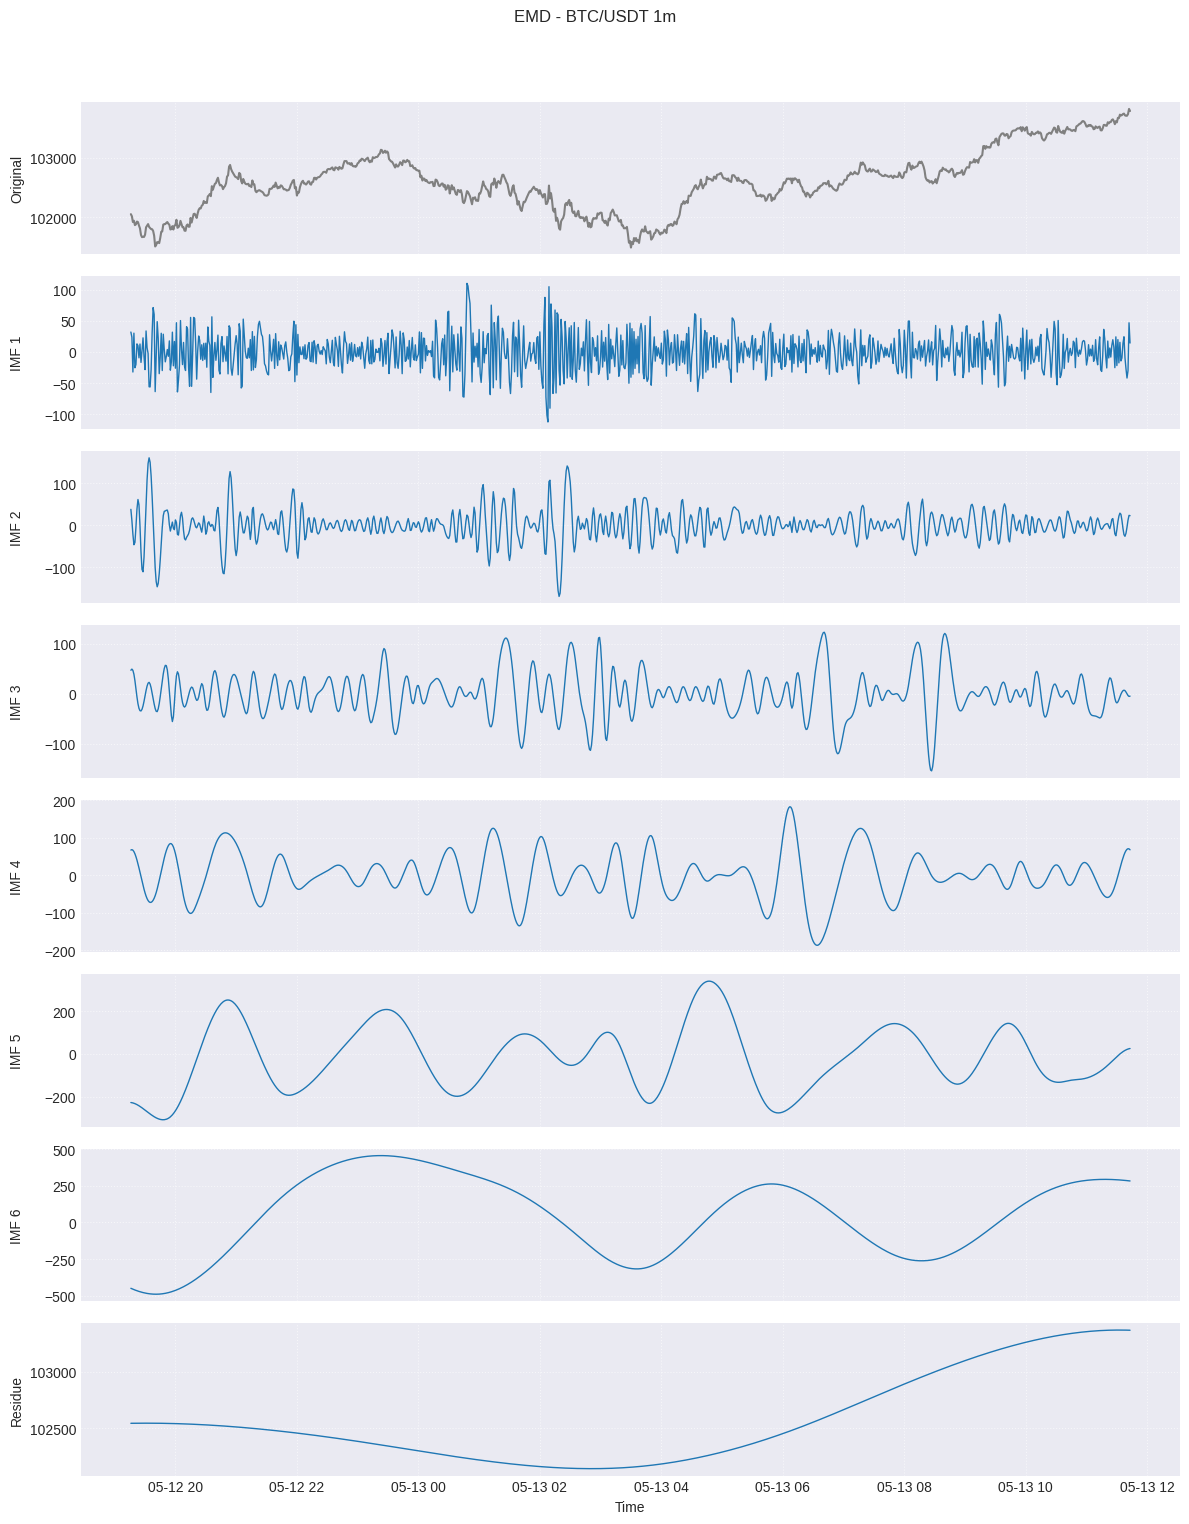

In [ ]:
# --- 3. Visualize Data (if prepared) ---
if 'bot' in locals() and bot_initialized and prepared_data is not None and not prepared_data.empty:
    print("\n--- Visualizing Data ---")
    # Plot EMD if PyEMD is available
    if HAS_PYEMD:
        bot.plot_emd_decomposition(data=prepared_data)
    else:
         print("\nSkipping EMD plot: PyEMD not available.")

    # Plot Features vs Price
    # Default features determined inside the function based on config and availability
    # Note: L2 features will only plot if they have non-NaN values (i.e., were pre-merged)
    bot.plot_features_vs_price(df=prepared_data)
else:
    print("\nSkipping Data Visualization (Bot not initialized or no prepared data).")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


--- Training Model ---

Model training successful.

--- Plotting Feature Importance ---


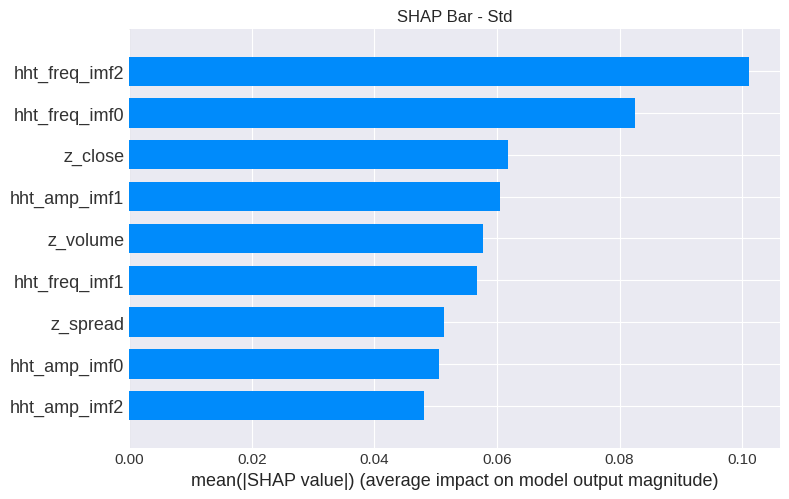

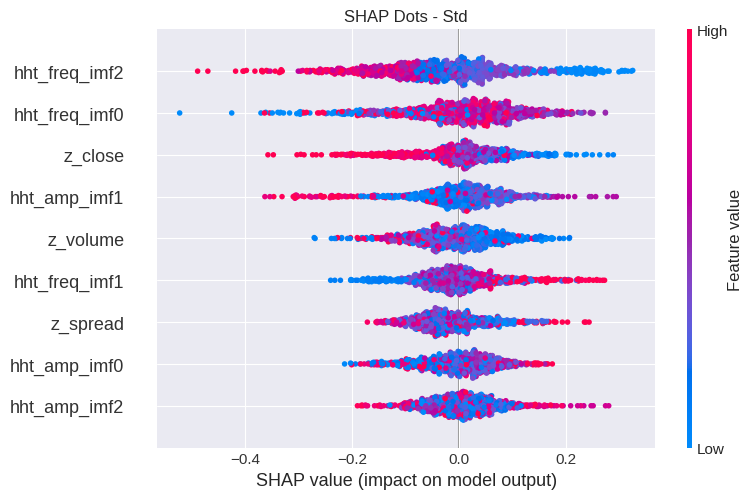

In [ ]:
# --- 4. Train Model ---
trained_model_booster = None # Initialize
if 'bot' in locals() and bot_initialized and prepared_data is not None and not prepared_data.empty:
    print("\n--- Training Model ---")
    # train_model uses config['optuna_trials'], config['test_size'] internally
    # It will determine features based on config['use_l2_features'] and data availability
    # It will WARN if L2 features are enabled but NaN in training data.
    trained_model_booster = bot.train_model(df=prepared_data, save=True)
    if not trained_model_booster:
        print("\nModel training failed.")
        # Handle error
    else:
         print("\nModel training successful.")

         # --- 5. Plot Feature Importance ---
         print("\n--- Plotting Feature Importance ---")
         # plot_feature_importance uses config['use_shap_override'] internally
         bot.plot_feature_importance(model_booster=trained_model_booster)

else:
    print("\nSkipping Model Training (Bot not initialized or no prepared data).")


In [ ]:
# --- 6. Run Backtest ---
if 'bot' in locals() and bot_initialized and trained_model_booster is not None:
    print("\n--- Running Backtest ---")
    # backtest uses config for defaults (threshold, commission, leverage, sl/tp)
    # It will load the prepared data and predict signals using the trained model
    # Note: L2 features will likely be NaN during backtest unless historical L2 was pre-merged.
    backtest_results_df, trades_log_df = bot.backtest(df=None) # Pass df=None to force loading/predicting

    if trades_log_df is not None and not trades_log_df.empty:
          print("\nBacktest Trades Log Sample:")
          # Display more rows if needed
          with pd.option_context('display.max_rows', 10, 'display.max_columns', None, 'display.width', 1000):
               print(trades_log_df.head())
    elif trades_log_df is not None: # Check if it's an empty DataFrame
          print("\nNo trades executed during backtest.")
    else: # Backtest failed (returned None, None)
         print("\nBacktest did not produce results. Check logs for errors.")
else:
    print("\nSkipping Backtest (Bot not initialized or model not trained).")



--- Running Backtest ---

Backtest did not produce results. Check logs for errors.



--- Live Simulation Section ---
*** Live Simulation will attempt to fetch L2 snapshots and calculate L2 features. ***
Attempting to run live simulation for approx 300 seconds...
Error (SmartExec) placing order for BTC/USDT: bybit {"retCode":10024,"retMsg":"Dear User, The product or service you are seeking to access is not available to you due to regulatory restrictions. If you believe you are a permitted customer of this product or service, please contact our Customer Support(/en/help-center/s/webform) for assistance. Thank You.","result":{"config":{"endpointExec":"KYC_PROMPT_TOAST","endpointArgs":{}}},"retExtInfo":{},"time":1747265641214}
Error (SmartExec) placing order for BTC/USDT: bybit {"retCode":10024,"retMsg":"Dear User, The product or service you are seeking to access is not available to you due to regulatory restrictions. If you believe you are a permitted customer of this product or service, please contact our Customer Support(/en/help-center/s/webform) for assistance. Thank

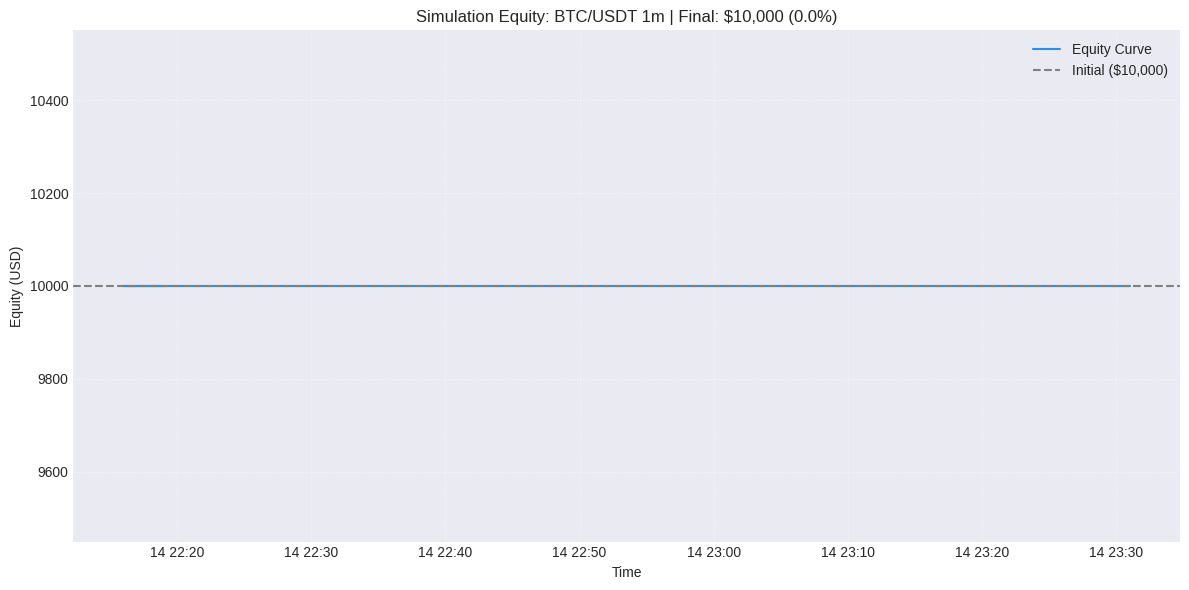


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
Notebook Execution Finished


In [ ]:
# --- 7. Run Live Simulation (Optional) ---
if 'bot' in locals() and bot_initialized and trained_model_booster is not None:
    print("\n--- Live Simulation Section ---")
    run_simulation = config.get('run_simulation_flag', False) # Get from config
    sim_duration = config.get('simulation_duration_seconds', 600)

    if run_simulation:
        if not bot.api_key or not bot.api_secret:
             print("\n*** WARNING: Live simulation started without API keys. Real trading actions would fail. ***")
             # L2 fetching might also fail without API keys depending on exchange
             if config.get('use_l2_features', False):
                  print("*** L2 fetching in simulation might fail without API keys. ***")

        # Check if L2 features are enabled and if fetching is possible
        if config.get('use_l2_features', False):
            if bot.exchange and bot.exchange.has.get('fetchL2OrderBook'):
                print("*** Live Simulation will attempt to fetch L2 snapshots and calculate L2 features. ***")
            else:
                 print("*** WARNING: L2 features enabled, but exchange/CCXT does not support fetchL2OrderBook. L2 features will be NaN in simulation. ***")

        print(f"Attempting to run live simulation for approx {sim_duration} seconds...")
        # run_live_simulation uses config for defaults
        bot.run_live_simulation()
        try:
            start_sim_time = time.time()
            while bot.simulation_running and (time.time() - start_sim_time) < sim_duration:
                print(f"Simulation running... (Time elapsed: {int(time.time() - start_sim_time)}s / {sim_duration}s)", end='\r')
                time.sleep(5)
            print("\nSimulation duration reached or stop signaled.")
        except KeyboardInterrupt: print("\nKeyboard interrupt detected. Stopping simulation...")
        finally:
            if bot.simulation_running: bot.stop_live_simulation() # Ensure simulation stops cleanly
    else:
        print("RUN_SIMULATION_FLAG is set to False in config. Skipping live simulation.")
else:
    print("\nSkipping Simulation (Bot not initialized or model not trained).")


print("\n="*50)
print("Notebook Execution Finished")
print("="*50)

# Keep plots open if not in interactive mode (e.g., running as script)
# Check if plt was successfully imported
# if 'plt' in locals() and plt is not None:
#      INTERACTIVE_MODE = 'ipykernel' in sys.modules
#      if not INTERACTIVE_MODE:
#          print("Displaying plots. Close plot windows to exit.")
#          plt.show()